In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Importing libraries

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [5]:
## Pandas Display options
pd.set_option('display.max_columns',0)
pd.set_option('display.max_colwidth',0)

## Read data

In [7]:
## Reading relevant data
match_lvl_data = pd.read_csv('match_level_scorecard.csv')
batsman_lvl_data = pd.read_csv('batsman_level_scorecard.csv')
bowler_lvl_data = pd.read_csv('bowler_level_scorecard.csv')
train_data = pd.read_csv('train_data_with_samplefeatures.csv')
test_data = pd.read_csv('r2_data_with_samplefeatures.csv')

## Data Cleaning
### Handling Missing values

In [9]:
## Check Null Values
##Check features with nan value
train_data.isnull().sum()

match id                     0 
team1                        0 
team1_id                     0 
team1_roster_ids             0 
team2                        0 
team2_id                     0 
team2_roster_ids             0 
winner                       0 
winner_id                    0 
toss winner                  0 
toss decision                0 
venue                        0 
city                         0 
match_dt                     0 
lighting                     0 
series_name                  0 
season                       0 
ground_id                    0 
team_count_50runs_last15     0 
team_winp_last5              0 
team1only_avg_runs_last15    21
team1_winp_team2_last15      0 
ground_avg_runs_last15       53
dtype: int64

In [10]:
train_data.describe()

match id      team1_id  ...  team1_winp_team2_last15  ground_avg_runs_last15
count  9.480000e+02  948.000000    ...  948.000000               895.000000            
mean   9.323234e+06  21921.722574  ...  40.991561                153.822446            
std    2.302622e+05  17657.672717  ...  37.948831                13.971631             
min    8.797053e+06  20.000000     ...  0.000000                 81.500000             
25%    9.097078e+06  6838.000000   ...  0.000000                 145.381818            
50%    9.330600e+06  18360.000000  ...  40.000000                154.666667            
75%    9.484520e+06  36126.000000  ...  66.670000                162.426768            
max    9.887863e+06  49657.000000  ...  100.000000               209.500000            

[8 rows x 10 columns]

# Printing shape and sample rows of each dataset

In [12]:
train_data.shape
train_data.head(2)

(948, 23)

match id team1  team1_id  ... team1only_avg_runs_last15 team1_winp_team2_last15  ground_avg_runs_last15
0  9331181   Ba    11283     ...  139.0                     100.0                   157.178571            
1  8797060   Ed    20        ...  156.0                     50.0                    103.500000            

[2 rows x 23 columns]

In [13]:
test_data.shape
test_data.head(2)

(207, 21)

match id  team1  team1_id  ... team1only_avg_runs_last15 team1_winp_team2_last15  ground_avg_runs_last15
0  9272619   Me Ss  33949     ...  167.933333                60.0                    154.115385            
1  9086958   Na     209       ...  141.888889                0.0                     142.833333            

[2 rows x 21 columns]

In [14]:
match_lvl_data.shape
match_lvl_data.head(2)

(1689, 30)

match id  team1  team2  ...     series_type winner_id  player_of_the_match_id
0  8638034   Nn Ds  Wn     ...  other_domestic  18570    NaN                    
1  8588005   Me Rs  Sy Tr  ...  other_domestic  33963     1749075.0             

[2 rows x 30 columns]

In [15]:
batsman_lvl_data.shape
batsman_lvl_data.head(2)

(24483, 21)

match id batsman  batsman_id                           batsman_details  ...  strike_rate  Fours  Sixes    match_dt
0  8638034   KD Ce   7907451.0   NZ:Right-hand bat:Right-arm medium-fast:  ...  140.0        1.0   NaN     2021-01-01
1  8638034   TL St   4381761.0   NZ:Right-hand bat:None:                   ...  100.0        4.0    1.0    2021-01-01

[2 rows x 21 columns]

In [16]:
bowler_lvl_data.shape
bowler_lvl_data.head(2)

(18539, 18)

match id bowler  bowler_id                            bowler_details  ...  Sixes  wides  noballs    match_dt
0  8638034   BV Ss  6718396.0  NZ:Right-hand bat:Right-arm medium-fast:  ...  1      3      1        2021-01-01
1  8638034   HK Bt  1585464.0  NZ:Left-hand bat:Right-arm medium-fast:   ...  1      2      0        2021-01-01

[2 rows x 18 columns]

#### Create dependent column

In [18]:
## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 1 if (x['team2']==x['winner']) else 0, axis=1)

#### Pre process

In [20]:
## Toss winner to numerical - 1 if team2 wins, else 0

train_data['toss_winner_01'] = np.where(train_data['toss winner']==train_data['team2'], 1, 0)
test_data['toss_winner_01'] = np.where(test_data['toss winner']==test_data['team2'], 1, 0)

In [21]:
## Toss decision - categorical - 1 if winner bats, 0 otherwise

train_data['toss_decision_01'] = np.where(train_data['toss decision']=='bat', 1, 0)
test_data['toss_decision_01'] = np.where(test_data['toss decision']=='bat', 1, 0)

In [22]:
# ## Code to plot RnP

from matplotlib import pyplot as plt
import seaborn as sns

sns.set()
import re

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();

In [23]:
# #### Helper function

def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'
        
    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False).head(n)

In [24]:
def get_last_5_matches(team_id, match2, match_date):
    team_matches = match2[((match2['team1_id'] == team_id) | (match2['team2_id'] == team_id)) & (match2['match_dt'] < match_date)]
    team_matches = team_matches.sort_values(by='match_dt', ascending=False).head(5)
    return team_matches['match id'].tolist()

In [25]:
matches=match_lvl_data

In [26]:
# Sort the matches by date
matches = matches.sort_values(by='match_dt')

In [27]:
percentage_first_match_win = []
teams = pd.concat([matches['team1_id'], matches['team2_id']]).unique()

for index, row in train_data.iterrows():
    match_id = row['match id']
    team1_id = row['team1_id']
    team2_id = row['team2_id']
    match_date = row['match_dt']
    team1_matches = get_last_5_matches(team1_id, match_lvl_data, match_date)
    team2_matches = get_last_5_matches(team2_id, match_lvl_data, match_date)
    
    if (len(team1_matches) == 0) or (len(team2_matches) == 0):
        matches_mod = matches[matches['match_dt'] < match_date].copy()
        results = []
        
        for team in teams:
            team_matches = matches_mod.loc[(matches_mod['team1_id'] == team) | (matches_mod['team2_id'] == team)]
            
            if not team_matches.empty:
                first_match = team_matches.iloc[0]
                
                # Determine the result of the first match
                if first_match['winner_id'] == team:
                    results.append(1)
                else:
                    results.append(0)
        
        # Calculate the percentage of teams that won their first match
        if results:
            percentage_won_first_match = sum(results) / len(results)
        else:
            percentage_won_first_match = 0
        
        percentage_first_match_win.append(percentage_won_first_match)
    else:
        percentage_first_match_win.append(0)

In [28]:
# Add the new column to the train_data
train_data['percent_won_first_match'] = percentage_first_match_win

In [29]:
x=train_data[train_data['percent_won_first_match']!=0]

In [30]:
x

match id     team1  team1_id  ... toss_winner_01 toss_decision_01  percent_won_first_match
19   9657059   Ra        1350      ...  0              1                0.497006               
28   9076815   Mr Gp Da  40452     ...  1              0                0.503817               
37   9407614   Pa Cs     48929     ...  1              0                0.496970               
56   9249162   Ch Rc     895       ...  1              0                0.500000               
81   9097479   Ud Ab Es  202       ...  1              0                0.507143               
164  9407600   Pl Rs     48950     ...  1              0                0.496894               
179  9250387   Se        174       ...  0              1                0.493421               
183  9407607   Jg Sr Ks  48922     ...  0              1                0.496933               
207  9849713   Na        1224      ...  0              1                0.485549               
215  9327492   Ka        195       ...  0              1                0.493671               
321  9076857   Ca Vs     40298     ...  1              0                0.503704               
351  9327499   Ga        958       ...  0              1                0.493590               
370  9076885   Cm Cs     40424     ...  1              0                0.507353               
401  9128405   Gt Ts     48341     ...  1              0                0.500000               
406  9680173   Co Ss     47487     ...  0              1                0.491124               
428  9250268   Ze        76        ...  1              0                0.500000               
439  9097332   Wn Pe     23869     ...  0              1                0.510638               
479  9299331   Ka        195       ...  1              0                0.500000               
510  9681510   Dk        104       ...  0              1                0.494048               
526  9250310   Hg Kg     146       ...  0              1                0.496689               
537  9749697   Ud Ab Es  202       ...  0              1                0.491228               
542  9097045   Ca        132       ...  0              1                0.500000               
585  9097024   Id        216       ...  0              1                0.507042               
593  9327485   Ba        825       ...  1              0                0.496774               
625  9680187   Ge Ts     49650     ...  0              1                0.488235               
744  9457384   Rr Rs     35790     ...  1              0                0.493750               
748  9301963   Ud Ab Es  202       ...  1              0                0.496732               
780  9837218   On        272       ...  0              1                0.488372               
785  9097164   On        272       ...  1              0                0.503597               
850  9097017   Ud Ab Es  202       ...  0              1                0.507042               
871  9128384   Ci Sr Ks  30414     ...  1              0                0.496552               
894  9076808   Cm Cs     40424     ...  1              0                0.503817               
901  9167920   Ua        251       ...  1              0                0.503401               
930  9327548   Ta        1490      ...  1              0                0.496855               
945  9097227   Bd        22497     ...  0              1                0.503650               

[35 rows x 27 columns]

In [31]:
percentage_first_match_win = []
teams = pd.concat([matches['team1_id'], matches['team2_id']]).unique()

for index, row in test_data.iterrows():
    match_id = row['match id']
    team1_id = row['team1_id']
    team2_id = row['team2_id']
    match_date = row['match_dt']
    team1_matches = get_last_5_matches(team1_id, match_lvl_data, match_date)
    team2_matches = get_last_5_matches(team2_id, match_lvl_data, match_date)
    
    if (len(team1_matches) == 0) or (len(team2_matches) == 0):
        matches_mod = matches[matches['match_dt'] < match_date].copy()
        results = []
        
        for team in teams:
            team_matches = matches_mod.loc[(matches_mod['team1_id'] == team) | (matches_mod['team2_id'] == team)]
            
            if not team_matches.empty:
                first_match = team_matches.iloc[0]
                
                # Determine the result of the first match
                if first_match['winner_id'] == team:
                    results.append(1)
                else:
                    results.append(0)
        
        # Calculate the percentage of teams that won their first match
        if results:
            percentage_won_first_match = sum(results) / len(results)
        else:
            percentage_won_first_match = 0
        
        percentage_first_match_win.append(percentage_won_first_match)
    else:
        percentage_first_match_win.append(0)

In [32]:
# Add the new column to the train_data
test_data['percent_won_first_match'] = percentage_first_match_win

# ### 1. team_avg_Econ_last10 <br>
# Ratio of team's avg inning economy ratio in last 10 games

In [34]:
## derived feature computed using toss winner & toss decision to denote the inning team1 bats.
# If team1 won the toss and chose to bat or team2 won the toss and chose to bowl, the feature takes the value 1, else 2.
match_lvl_data['team1_bat_inning'] = np.where( ((match_lvl_data['team1']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='bat'))|\
                                               ((match_lvl_data['team2']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='field')) , 1, 2)

In [35]:
match_lvl_data.head(2)

match id  team1  team2 winner  ...     series_type  winner_id player_of_the_match_id team1_bat_inning
0  8638034   Nn Ds  Wn     Wn     ...  other_domestic  18570     NaN                     1              
1  8588005   Me Rs  Sy Tr  Sy Tr  ...  other_domestic  33963      1749075.0              1              

[2 rows x 31 columns]

In [36]:
def teamAvgEconLastn(team_id, date, n):
    
    # filter out games with either team1/2_id as input team_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    # combine two dataframes - one where input team is batting first, and another one where input team is batting second.
    # Separate and rename the runs and balls data for consistency
    df_runs = pd.concat([
        df_rel[df_rel['team1_bat_inning'] == 1][['inning2_runs']].rename(columns={'inning2_runs': 'runs'}),
        df_rel[df_rel['team1_bat_inning'] == 2][['inning1_runs']].rename(columns={'inning1_runs': 'runs'})
    ])
    
    df_balls = pd.concat([
        df_rel[df_rel['team1_bat_inning'] == 1][['inning2_balls']].rename(columns={'inning2_balls': 'balls'}),
        df_rel[df_rel['team1_bat_inning'] == 2][['inning1_balls']].rename(columns={'inning1_balls': 'balls'})
    ])
    
    # Combine the runs and balls dataframes
    df_combined = pd.concat([df_runs.reset_index(drop=True), df_balls.reset_index(drop=True)], axis=1)

    # Calculate the average economy rate (runs per ball)
    df_combined['avgEcon'] = df_combined['runs'] / df_combined['balls']

    # Return the mean of the average economy rate
    return df_combined['avgEcon'].mean() 

In [37]:
# Computing average Economy in last 10 games for team1 for train dataset.
train_data['team1_avg_Econ_last10'] = train_data.progress_apply(lambda x: \
            teamAvgEconLastn(x['team1_id'], x['match_dt'], 10), axis=1)
# Computing average Economy in last 10 games for team2 for train dataset.
train_data['team2_avg_Econ_last10'] = train_data.progress_apply(lambda x: \
            teamAvgEconLastn(x['team2_id'], x['match_dt'], 10), axis=1)

100%|███████████████████████████████████████████████████████████████████████████████| 948/948 [00:07<00:00, 129.80it/s]


In [38]:
# Taking ratio of (average Economy in last 10 games for team1) to (average Economy in last 10 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team_avg_Econ_last10'] = (train_data['team1_avg_Econ_last10']+1)/(train_data['team2_avg_Econ_last10']+1)
train_data.drop(columns=['team1_avg_Econ_last10','team2_avg_Econ_last10'], inplace=True) # dropping intermediate columns

In [39]:
train_data.shape
train_data.tail(2)

(948, 28)

match id  team1  team1_id  ... toss_decision_01 percent_won_first_match  team_avg_Econ_last10
946  9516695   Rn Rs  30428     ...  1                0.0                     0.977715            
947  9433633   He     7727      ...  0                0.0                     0.983385            

[2 rows x 28 columns]

slope: 0.46 / 0.46 =  1.01


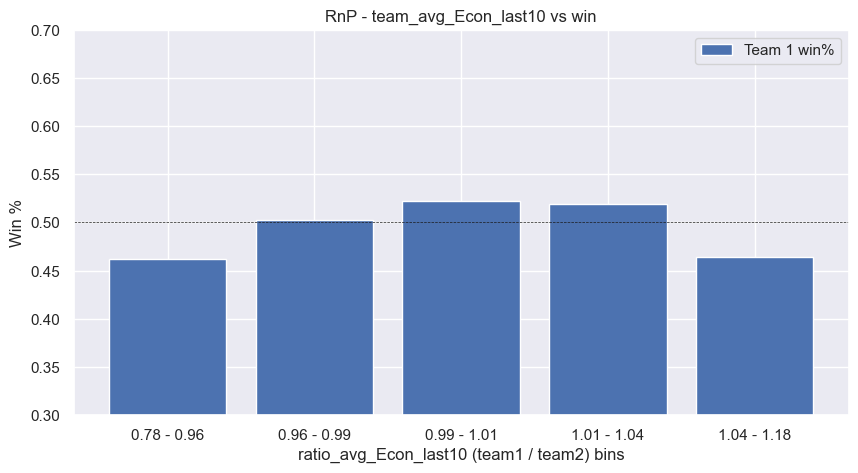

In [40]:
# RnP of team_avg_Econ_last10 computed over the train data. Slope denotes ratio of right most bin to left most bin.
createRnP(train_data, 'team_avg_Econ_last10')

In [41]:
## Doing similar process for test dataset

test_data['team1_avg_Econ_last10'] = test_data.progress_apply(lambda x: \
            teamAvgEconLastn(x['team1_id'], x['match_dt'], 10), axis=1)
test_data['team2_avg_Econ_last10'] = test_data.progress_apply(lambda x: \
            teamAvgEconLastn(x['team2_id'], x['match_dt'], 10), axis=1)
test_data['team_avg_Econ_last10'] = (test_data['team1_avg_Econ_last10']+1)/(test_data['team2_avg_Econ_last10']+1)
test_data.drop(columns=['team1_avg_Econ_last10','team2_avg_Econ_last10'], inplace=True) # dropping intermediate columns
test_data.shape
test_data.head(2)

100%|███████████████████████████████████████████████████████████████████████████████| 207/207 [00:01<00:00, 115.51it/s]


(207, 25)

match id  team1  team1_id  ... toss_decision_01 percent_won_first_match  team_avg_Econ_last10
0  9272619   Me Ss  33949     ...  0                0.0                     0.918329            
1  9086958   Na     209       ...  0                0.0                     0.895400            

[2 rows x 25 columns]

# ###2.team_srrate_ratio_last10 <br>
## Ratio of the average weighted strike rate of the top 3 batsman in the last 10 games

In [43]:
def get_last_10_matches(team_id, match2, match_date):
    team_matches = match2[((match2['team1_id'] == team_id) | (match2['team2_id'] == team_id)) & (match2['match_dt'] < match_date)]
    team_matches = team_matches.sort_values(by='match_dt', ascending=False).head(10)
    return team_matches['match id'].tolist()

In [44]:
def srT3Lastn(player_list, date, n):
    player_list = str(player_list).split(':')  # split string of ':' separated ids into a list of ids
    strike_rate_list = []
    
    for player in player_list:  # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')  # getting batting stats from last n games for each player
        total_runs = np.nansum(df_rel['runs'])  # Sum up number of runs for the player
        total_balls_faced = np.nansum(df_rel['balls_faced'])  # Sum up number of balls faced for the player
        strike_rate = (total_runs / total_balls_faced) * 100 if total_balls_faced > 0 else 0  # Calculate strike rate
        
        strike_rate_list.append((player, strike_rate, total_balls_faced))  # Append the player id, strike rate, and total balls faced as a tuple to the list
    
    # Sort the list by strike rate in descending order and take the top 3
    top_3_batsmen = sorted(strike_rate_list, key=lambda x: x[1], reverse=True)[:3]
    
    weighted_sr_list = []
    total_balls_top_3 = sum([batsman[2] for batsman in top_3_batsmen])  # Sum up the total balls faced by top 3 batsmen
    
    if total_balls_top_3 > 0:  # Ensure no division by zero
        for batsman in top_3_batsmen:
            weighted_sr_list.append(batsman[1] * (batsman[2] / total_balls_top_3))  # Weighted strike rate contribution
    
    return sum(weighted_sr_list) if top_3_batsmen else 0

In [45]:
# Applying the function to compute the number of wickets taken by top 3 bowlers for team1 and team2

tqdm.pandas() # to use progress_apply

# Training dataset
train_data['team1_srrate_top3_last10'] = train_data.progress_apply(lambda x: \
            srT3Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=10), axis=1)
train_data['team2_srrate_top3_last10'] = train_data.progress_apply(lambda x: \
            srT3Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=10), axis=1)

100%|████████████████████████████████████████████████████████████████████████████████| 948/948 [00:28<00:00, 33.69it/s]


In [46]:
# Calculating the ratio of wickets taken by top 3 bowlers of team1 to team2
train_data['team_srrate_ratio_last10'] = (train_data['team1_srrate_top3_last10'] + 1) / (train_data['team2_srrate_top3_last10'] + 1)
# Dropping intermediate columns
train_data.drop(columns=['team1_srrate_top3_last10', 'team2_srrate_top3_last10'], inplace=True)

In [47]:
train_data.head()

match id     team1  team1_id  ... percent_won_first_match team_avg_Econ_last10  team_srrate_ratio_last10
0  9331181   Ba        11283     ...  0.0                     0.988176             1.068458                
1  8797060   Ed        20        ...  0.0                     1.032209             0.917698                
2  9433269   We        10576     ...  0.0                     0.971167             0.946543                
3  9587073   Ga An Ws  36084     ...  0.0                     1.000301             1.272555                
4  9516457   Pb Ks     30407     ...  0.0                     1.030384             0.955331                

[5 rows x 29 columns]

slope: 0.58 / 0.38 =  1.52


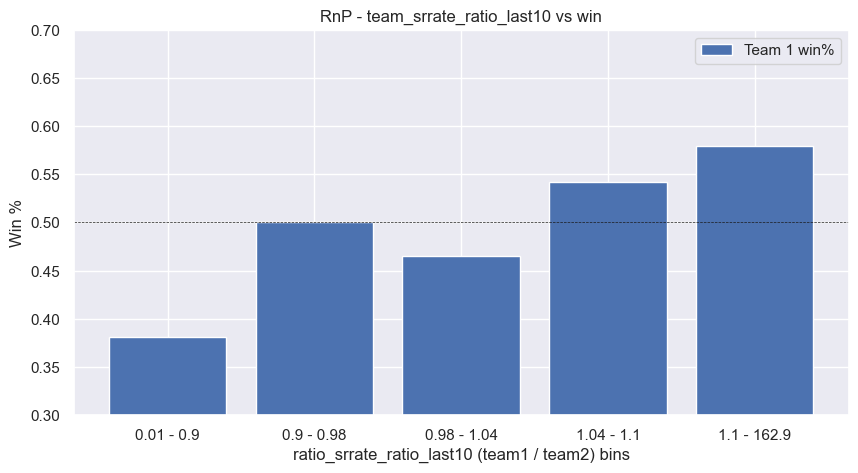

In [48]:
# RnP of team_count_50runs_last15 computed over the train data. Slope denotes ratio of right most bin to left most bin.
createRnP(train_data, 'team_srrate_ratio_last10')

In [49]:
## Doing similar process for test dataset

test_data['team1_srrate_top3_last10'] = test_data.progress_apply(lambda x: \
            srT3Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=10), axis=1)
test_data['team2_srrate_top3_last10'] = test_data.progress_apply(lambda x: \
            srT3Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=10), axis=1)

# Calculating the ratio of wickets taken by top 3 bowlers of team1 to team2
test_data['team_srrate_ratio_last10'] = (test_data['team1_srrate_top3_last10'] + 1) / (test_data['team2_srrate_top3_last10'] + 1)

# Dropping intermediate columns
test_data.drop(columns=['team1_srrate_top3_last10', 'team2_srrate_top3_last10'], inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:06<00:00, 32.86it/s]


In [50]:
test_data.head()

match id  team1  team1_id  ... percent_won_first_match team_avg_Econ_last10  team_srrate_ratio_last10
0  9272619   Me Ss  33949     ...  0.0                     0.918329             0.793796                
1  9086958   Na     209       ...  0.0                     0.895400             0.802167                
2  9433654   Gn     7573      ...  0.0                     1.042935             0.921746                
3  9097248   Ks     22784     ...  0.0                     1.028765             0.980566                
4  9097234   Ws     23841     ...  0.0                     1.021040             0.918488                

[5 rows x 26 columns]

# ###3. team_runs_ratio_last10 <br>
## Ratio of runs scored by top 3 batsmen of both teams

In [52]:
def runsT3Lastn(player_list, date, n):
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    runs_list = []
    
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') # getting bowling stats from last n games for each player
        total_runs = np.nansum(df_rel['runs']) # Sum up number of runs for the player
        runs_list.append((player, total_runs)) # Append the player id and total wickets as a tuple to the list
    
    # Sort the list by total runs in descending order and take the top 3
    top_3_batsmen = sorted(runs_list, key=lambda x: x[1], reverse=True)[:3]
    
    # Sum up the runs taken by the top 3 bowlers
    total_runs_top_3 = sum([batsman[1] for batsman in top_3_batsmen])
    
    return total_runs_top_3

In [53]:
# Applying the function to compute the number of wickets taken by top 3 bowlers for team1 and team2

tqdm.pandas() # to use progress_apply

# Training dataset
train_data['team1_runs_top3_last10'] = train_data.progress_apply(lambda x: \
            runsT3Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=10), axis=1)
train_data['team2_runs_top3_last10'] = train_data.progress_apply(lambda x: \
            runsT3Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=10), axis=1)

100%|████████████████████████████████████████████████████████████████████████████████| 948/948 [00:26<00:00, 35.20it/s]


In [54]:
# Calculating the ratio of wickets taken by top 3 bowlers of team1 to team2
train_data['team_runs_ratio_last10'] = (train_data['team1_runs_top3_last10'] + 1) / (train_data['team2_runs_top3_last10'] + 1)
# Dropping intermediate columns
train_data.drop(columns=['team1_runs_top3_last10', 'team2_runs_top3_last10'], inplace=True)

In [55]:
train_data.head()

match id     team1  team1_id  ... team_avg_Econ_last10 team_srrate_ratio_last10  team_runs_ratio_last10
0  9331181   Ba        11283     ...  0.988176             1.068458                 0.988662              
1  8797060   Ed        20        ...  1.032209             0.917698                 0.884000              
2  9433269   We        10576     ...  0.971167             0.946543                 0.778286              
3  9587073   Ga An Ws  36084     ...  1.000301             1.272555                 1.683241              
4  9516457   Pb Ks     30407     ...  1.030384             0.955331                 0.923155              

[5 rows x 30 columns]

slope: 0.62 / 0.41 =  1.52


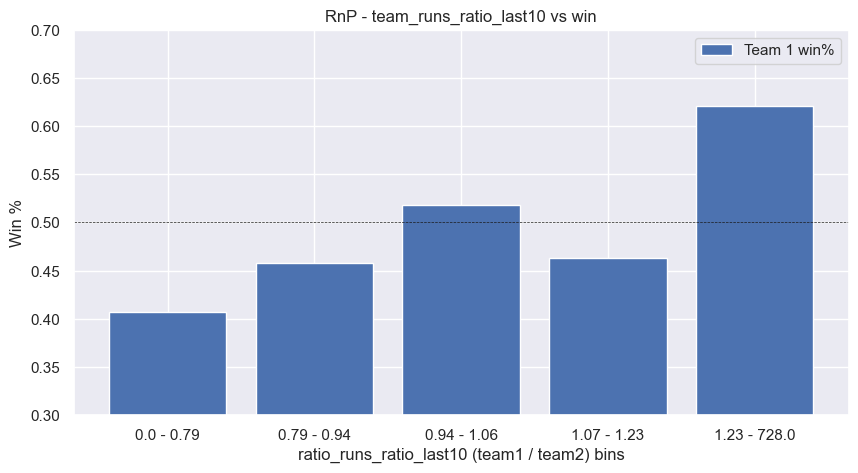

In [56]:
# RnP of team_count_50runs_last15 computed over the train data. Slope denotes ratio of right most bin to left most bin.
createRnP(train_data, 'team_runs_ratio_last10')

In [57]:
train_data.head()

match id     team1  team1_id  ... team_avg_Econ_last10 team_srrate_ratio_last10  team_runs_ratio_last10
0  9331181   Ba        11283     ...  0.988176             1.068458                 0.988662              
1  8797060   Ed        20        ...  1.032209             0.917698                 0.884000              
2  9433269   We        10576     ...  0.971167             0.946543                 0.778286              
3  9587073   Ga An Ws  36084     ...  1.000301             1.272555                 1.683241              
4  9516457   Pb Ks     30407     ...  1.030384             0.955331                 0.923155              

[5 rows x 30 columns]

In [58]:
## Doing similar process for test dataset

test_data['team1_runs_top3_last10'] = test_data.progress_apply(lambda x: \
            runsT3Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=10), axis=1)
test_data['team2_runs_top3_last10'] = test_data.progress_apply(lambda x: \
            runsT3Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=10), axis=1)

# Calculating the ratio of wickets taken by top 3 bowlers of team1 to team2
test_data['team_runs_ratio_last10'] = (test_data['team1_runs_top3_last10'] + 1) / (test_data['team2_runs_top3_last10'] + 1)

# Dropping intermediate columns
test_data.drop(columns=['team1_runs_top3_last10', 'team2_runs_top3_last10'], inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:06<00:00, 33.87it/s]


In [59]:
test_data.head()

match id  team1  team1_id  ... team_avg_Econ_last10 team_srrate_ratio_last10  team_runs_ratio_last10
0  9272619   Me Ss  33949     ...  0.918329             0.793796                 0.682353              
1  9086958   Na     209       ...  0.895400             0.802167                 0.624849              
2  9433654   Gn     7573      ...  1.042935             0.921746                 0.967141              
3  9097248   Ks     22784     ...  1.028765             0.980566                 0.925620              
4  9097234   Ws     23841     ...  1.021040             0.918488                 0.630037              

[5 rows x 27 columns]

# ###4.percentage_dot_balls_bowled_last_5 <br>
## Ratio of percentage of dot balls bowled by each team in the last 5 games

In [61]:
def get_last_5_matches(team_id, match2, match_date):
    team_matches = match2[((match2['team1_id'] == team_id) | (match2['team2_id'] == team_id)) & (match2['match_dt'] < match_date)]
    team_matches = team_matches.sort_values(by='match_dt', ascending=False).head(5)
    return team_matches['match id'].tolist()

In [62]:
train_data_new1=train_data
test_data_new1=test_data

In [63]:
## Toss winner to numerical - 1 if team2 wins, else 0

match_lvl_data['toss_winner_01'] = np.where(match_lvl_data['toss winner']==match_lvl_data['team2'], 1, 0)

In [64]:
## Toss decision - categorical - 1 if winner bats, 0 otherwise

match_lvl_data['toss_decision_01'] = np.where(match_lvl_data['toss decision']=='bat', 1, 0)

In [65]:
def calculate_team_dot_balls_bowled(match_id, team_id, bowler_df, train_df):
    match_data = train_df[train_df['match id'] == match_id]
    
    if len(match_data) == 0:
        print(f"No match data found for Match ID: {match_id}")
        return 0
    if match_data.iloc[0]['team1_id'] == team_id:
        if match_data.iloc[0]['toss_winner_01']==0 and match_data.iloc[0]['toss_decision_01']==1 :
            balls_bowled=match_data.iloc[0]['inning2_balls']
        elif match_data.iloc[0]['toss_winner_01']==0 and match_data.iloc[0]['toss_decision_01']==0 :
            balls_bowled=match_data.iloc[0]['inning1_balls']
        elif match_data.iloc[0]['toss_winner_01']==1 and match_data.iloc[0]['toss_decision_01']==0 :
            balls_bowled=match_data.iloc[0]['inning1_balls']
        else:
            balls_bowled=match_data.iloc[0]['inning2_balls']
        team_roster_ids = match_data.iloc[0]['team1_roster_ids'].split(':')
    elif match_data.iloc[0]['team2_id'] == team_id:
        if match_data.iloc[0]['toss_winner_01']==0 and match_data.iloc[0]['toss_decision_01']==1 :
            balls_bowled=match_data.iloc[0]['inning1_balls']
        elif match_data.iloc[0]['toss_winner_01']==0 and match_data.iloc[0]['toss_decision_01']==0 :
            balls_bowled=match_data.iloc[0]['inning2_balls']
        elif match_data.iloc[0]['toss_winner_01']==1 and match_data.iloc[0]['toss_decision_01']==0 :
            balls_bowled=match_data.iloc[0]['inning2_balls']
        else:
            balls_bowled=match_data.iloc[0]['inning1_balls']
        team_roster_ids = match_data.iloc[0]['team2_roster_ids'].split(':')
    else:
        print(f"Team ID {team_id} not found in Match ID {match_id}")
        return 0
    team_roster_ids = [id.split('.')[0] for id in team_roster_ids]
    
    match_bowler_data = bowler_df[bowler_df['match id'] == match_id].copy()
    match_bowler_data['bowler_id'] = match_bowler_data['bowler_id'].astype(str)
    match_bowler_data['bowler_id'] = match_bowler_data['bowler_id'].apply(lambda x: x.split('.')[0])  
    team_bowlers = match_bowler_data[match_bowler_data['bowler_id'].isin(team_roster_ids)]
    dot_balls_bowled = team_bowlers['dots'].sum()
    percentage_dot_balls_bowled=dot_balls_bowled/balls_bowled
    
    return percentage_dot_balls_bowled*100

In [66]:
percentage_dot_balls_ratio = []
for index, row in train_data.iterrows():
    match_id = row['match id']
    team1_id = row['team1_id']
    team2_id = row['team2_id']
    match_date = row['match_dt']
    
    team1_last_5_matches = get_last_5_matches(team1_id, match_lvl_data, match_date)
    team2_last_5_matches = get_last_5_matches(team2_id, match_lvl_data, match_date)
    
    team1_percentage_dotballs_bowled = []
    team2_percentage_dotballs_bowled = []

    for match in team1_last_5_matches:
        team1_percentage_dotballs_bowled.append(calculate_team_dot_balls_bowled(match, team1_id, bowler_lvl_data, match_lvl_data ))
    for match in team2_last_5_matches:
        team2_percentage_dotballs_bowled.append(calculate_team_dot_balls_bowled(match, team2_id, bowler_lvl_data, match_lvl_data ))
    if len(team1_last_5_matches) == 0 or len(team2_last_5_matches) == 0:
        percentage_dot_balls_ratio.append(np.nan)
        continue
    else:
        percentage_dot_balls_ratio.append(((sum(team1_percentage_dotballs_bowled)/len(team1_last_5_matches))+1)/((sum(team2_percentage_dotballs_bowled)/len(team2_last_5_matches))+1))

In [67]:
train_data['percentage_dot_balls_bowled_last_5']=percentage_dot_balls_ratio

In [68]:
train_data.head()

match id     team1  team1_id  ... team_srrate_ratio_last10 team_runs_ratio_last10  percentage_dot_balls_bowled_last_5
0  9331181   Ba        11283     ...  1.068458                 0.988662               1.539076                          
1  8797060   Ed        20        ...  0.917698                 0.884000               1.179855                          
2  9433269   We        10576     ...  0.946543                 0.778286               0.926225                          
3  9587073   Ga An Ws  36084     ...  1.272555                 1.683241               0.998687                          
4  9516457   Pb Ks     30407     ...  0.955331                 0.923155               1.030191                          

[5 rows x 31 columns]

In [69]:
percentage_dot_balls_ratio = []
for index, row in test_data_new1.iterrows():
    match_id = row['match id']
    team1_id = row['team1_id']
    team2_id = row['team2_id']
    match_date = row['match_dt']
    
    team1_last_5_matches = get_last_5_matches(team1_id, match_lvl_data, match_date)
    team2_last_5_matches = get_last_5_matches(team2_id, match_lvl_data, match_date)
    
    team1_percentage_dotballs_bowled = []
    team2_percentage_dotballs_bowled = []

    for match in team1_last_5_matches:
        team1_percentage_dotballs_bowled.append(calculate_team_dot_balls_bowled(match, team1_id, bowler_lvl_data, match_lvl_data ))
    for match in team2_last_5_matches:
        team2_percentage_dotballs_bowled.append(calculate_team_dot_balls_bowled(match, team2_id, bowler_lvl_data, match_lvl_data ))
    if len(team1_last_5_matches) == 0 or len(team2_last_5_matches) == 0:
        percentage_dot_balls_ratio.append(np.nan)
        continue
    else:
        percentage_dot_balls_ratio.append(((sum(team1_percentage_dotballs_bowled)/len(team1_last_5_matches))+1)/((sum(team2_percentage_dotballs_bowled)/len(team2_last_5_matches))+1))

In [70]:
test_data['percentage_dot_balls_bowled_last_5']=percentage_dot_balls_ratio

In [71]:
test_data.head()

match id  team1  team1_id  ... team_srrate_ratio_last10 team_runs_ratio_last10  percentage_dot_balls_bowled_last_5
0  9272619   Me Ss  33949     ...  0.793796                 0.682353               1.077462                          
1  9086958   Na     209       ...  0.802167                 0.624849               1.275008                          
2  9433654   Gn     7573      ...  0.921746                 0.967141               0.744014                          
3  9097248   Ks     22784     ...  0.980566                 0.925620               0.909201                          
4  9097234   Ws     23841     ...  0.918488                 0.630037               0.854452                          

[5 rows x 28 columns]

slope: 0.49 / 0.39 =  1.26


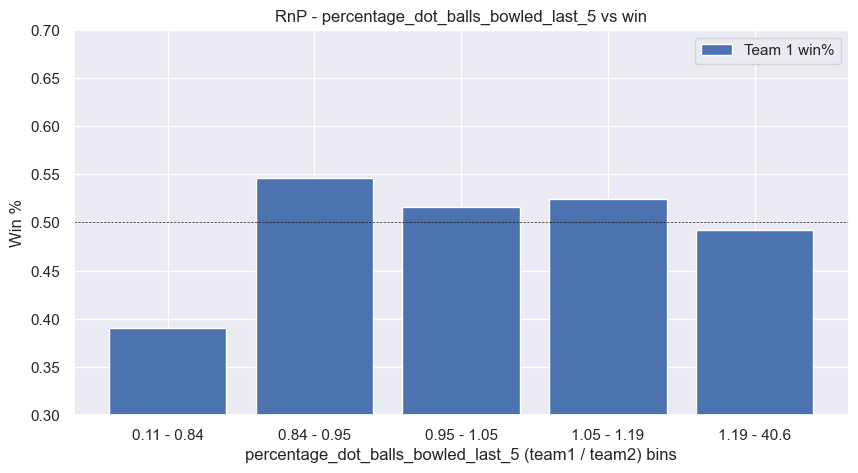

In [72]:
# RnP of team_avg_Econ_last10 computed over the train data. Slope denotes ratio of right most bin to left most bin.
createRnP(train_data, 'percentage_dot_balls_bowled_last_5')

# ###5.pitch condition <br>
## Who's winning chasing team or defending team 

In [74]:
match_lvl_data['toss_winner_01'] = (match_lvl_data['toss winner'] == match_lvl_data['team2']).astype(int)
match_lvl_data['toss_decision_01'] = (match_lvl_data['toss decision'] == 'bat').astype(int)
match_lvl_data['winner_01'] = (match_lvl_data['winner'] == match_lvl_data['team2']).astype(int)

In [75]:
match_lvl_data.sample()

match id  team1 team2 winner  ... team1_bat_inning  toss_winner_01 toss_decision_01 winner_01
31  8710232   Ma Ph  Ga    Ma Ph  ...  1                1               0                0       

[1 rows x 34 columns]

In [76]:
def pitch_condn(ground_id, date, team1_bat_inning):
    
    # filter out games with either team1/2_id as input ground_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
    df = match_lvl_data[(match_lvl_data['match_dt']<date)].sort_values(by='match_dt', ascending=False)
    df_rel = df[df['ground_id'] == ground_id] 
    df_rel['chase_win'] = np.where(
        (((df_rel['toss_winner_01'] == 1) & (df_rel['toss_decision_01'] == 0)) | ((df_rel['toss_winner_01'] == 0) & (df_rel['toss_decision_01'] == 1))) & (df_rel['winner_01'] == 0),
        0,
        np.where(
            (((df_rel['toss_winner_01'] == 1) & (df_rel['toss_decision_01'] == 1)) | ((df_rel['toss_winner_01'] == 0) & (df_rel['toss_decision_01'] == 0))) & (df_rel['winner_01'] == 1),
            0,
            1
        )
    )
    
    if(df_rel.shape[0] != 0):
        if(team1_bat_inning == 2):
            return sum(df_rel['chase_win'])/df_rel.shape[0]
        else:
            return 1-(sum(df_rel['chase_win'])/df_rel.shape[0])
    else:
        return float('nan')

In [77]:
match_lvl_data[match_lvl_data['ground_id'] == 1469]

match id     team1     team2    winner  ... team1_bat_inning  toss_winner_01 toss_decision_01 winner_01
897   9587045   To Kt Rs  Ga An Ws  Ga An Ws  ...  1                1               0                1       
969   9262140   To Kt Rs  Ga An Ws  To Kt Rs  ...  1                1               0                0       
1196  9262126   To Kt Rs  Bs Rs     Bs Rs     ...  1                1               0                1       
1361  9587052   To Kt Rs  Bs Rs     To Kt Rs  ...  1                1               0                0       

[4 rows x 34 columns]

In [78]:
train_data['team1_bat_inning'] = np.where( ((train_data['team1']==train_data['toss winner'])&(train_data['toss decision']=='bat'))|\
                                        ((train_data['team2']==train_data['toss winner'])&(train_data['toss decision']=='field')) , 1, 2)
train_data['pitch condition'] = train_data.progress_apply(lambda x: \
            pitch_condn(x['ground_id'], x['match_dt'], x['team1_bat_inning']), axis=1)

100%|███████████████████████████████████████████████████████████████████████████████| 948/948 [00:04<00:00, 195.39it/s]


In [79]:
train_data['pitch condition'].sample(5)

378    0.625000
13     0.571429
858    0.400000
230    0.500000
140    0.333333
Name: pitch condition, dtype: float64

slope: 0.55 / 0.47 =  1.17


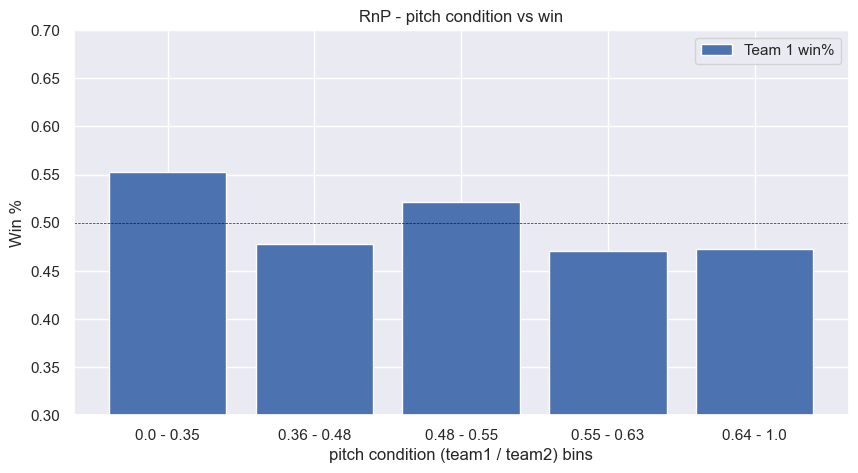

In [80]:
createRnP(train_data, 'pitch condition')

In [81]:
## Doing similar process for test dataset

test_data['team1_avg_Econ_last10'] = test_data.progress_apply(lambda x: \
            teamAvgEconLastn(x['team1_id'], x['match_dt'], 10), axis=1)
test_data['team2_avg_Econ_last10'] = test_data.progress_apply(lambda x: \
            teamAvgEconLastn(x['team2_id'], x['match_dt'], 10), axis=1)
test_data['team_avg_Econ_last10'] = (test_data['team1_avg_Econ_last10']+1)/(test_data['team2_avg_Econ_last10']+1)
test_data.drop(columns=['team1_avg_Econ_last10','team2_avg_Econ_last10'], inplace=True) # dropping intermediate columns
test_data['team1_bat_inning'] = np.where( ((test_data['team1']==test_data['toss winner'])&(test_data['toss decision']=='bat'))|\
                                        ((test_data['team2']==test_data['toss winner'])&(test_data['toss decision']=='field')) , 1, 2)
test_data['pitch condition'] = test_data.progress_apply(lambda x: \
            pitch_condn(x['ground_id'], x['match_dt'], x['team1_bat_inning']), axis=1)
test_data.shape
test_data.head(2)

100%|███████████████████████████████████████████████████████████████████████████████| 207/207 [00:01<00:00, 199.12it/s]


(207, 30)

match id  team1  team1_id  ... percentage_dot_balls_bowled_last_5 team1_bat_inning  pitch condition
0  9272619   Me Ss  33949     ...  1.077462                           1                0.615385       
1  9086958   Na     209       ...  1.275008                           1                0.666667       

[2 rows x 30 columns]

In [82]:
test_data['pitch condition']

0      0.615385
1      0.666667
2      0.571429
3      0.000000
4     NaN      
       ..      
202    0.500000
203    0.375000
204    0.375000
205    0.600000
206    0.600000
Name: pitch condition, Length: 207, dtype: float64

# ### 6. team_wickets_ratio_last10 <br>
# Ratio of number of wickets taken by the top 3 bowlers in the roster of a team in the last 10 games.

In [84]:
def noWsT3Lastn(player_list, date, n):
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    wickets_list = []
    
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl') # getting bowling stats from last n games for each player
        total_wickets = np.nansum(df_rel['wicket_count']) # Sum up number of wickets for the player
        wickets_list.append((player, total_wickets)) # Append the player id and total wickets as a tuple to the list
    
    # Sort the list by total wickets in descending order and take the top 3
    top_3_bowlers = sorted(wickets_list, key=lambda x: x[1], reverse=True)[:3]
    
    # Sum up the wickets taken by the top 3 bowlers
    total_wickets_top_3 = sum([w[1] for w in top_3_bowlers])
    
    return total_wickets_top_3

In [85]:
# Applying the function to compute the number of wickets taken by top 3 bowlers for team1 and team2

tqdm.pandas() # to use progress_apply

# Training dataset
train_data['team1_wickets_top3_last10'] = train_data.progress_apply(lambda x: \
            noWsT3Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=10), axis=1)
train_data['team2_wickets_top3_last10'] = train_data.progress_apply(lambda x: \
            noWsT3Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=10), axis=1)

100%|████████████████████████████████████████████████████████████████████████████████| 948/948 [00:22<00:00, 42.13it/s]


In [86]:
# Calculating the ratio of wickets taken by top 3 bowlers of team1 to team2
train_data['team_wickets_ratio_last10'] = (train_data['team1_wickets_top3_last10'] + 1) / (train_data['team2_wickets_top3_last10'] + 1)
# Dropping intermediate columns
train_data.drop(columns=['team1_wickets_top3_last10', 'team2_wickets_top3_last10'], inplace=True)

In [87]:
train_data.shape
train_data.tail(2)

(948, 34)

match id  team1  team1_id  ... team1_bat_inning pitch condition  team_wickets_ratio_last10
946  9516695   Rn Rs  30428     ...  1                0.375000        0.951220                 
947  9433633   He     7727      ...  1                0.461538        0.923077                 

[2 rows x 34 columns]

In [88]:
# RnP of team_count_50runs_last15 computed over the train data. Slope denotes ratio of right most bin to left most bin.
createRnP(train_data, 'team_wickets_ratio_last10')

slope: 0.58 / 0.42 =  1.39


In [89]:
## Doing similar process for test dataset

test_data['team1_wickets_top3_last10'] = test_data.progress_apply(lambda x: \
            noWsT3Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=10), axis=1)
test_data['team2_wickets_top3_last10'] = test_data.progress_apply(lambda x: \
            noWsT3Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=10), axis=1)

# Calculating the ratio of wickets taken by top 3 bowlers of team1 to team2
test_data['team_wickets_ratio_last10'] = (test_data['team1_wickets_top3_last10'] + 1) / (test_data['team2_wickets_top3_last10'] + 1)

# Dropping intermediate columns
test_data.drop(columns=['team1_wickets_top3_last10', 'team2_wickets_top3_last10'], inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:04<00:00, 41.48it/s]


In [90]:
test_data.shape
test_data.head(2)

(207, 31)

match id  team1  team1_id  ... team1_bat_inning pitch condition  team_wickets_ratio_last10
0  9272619   Me Ss  33949     ...  1                0.615385        1.111111                 
1  9086958   Na     209       ...  1                0.666667        1.192308                 

[2 rows x 31 columns]

# ### 7. percentage_runs_through_boundaries_last_5_ratio <br>
# Ratio of the runs through boundaries for the two teams in the last 5 games

In [92]:
def percentage_runs_through_boundaries(match_id, team_id, batsman_df, train_df):
    match_data = train_df[train_df['match id'] == match_id]
    
    if len(match_data) == 0:
        print(f"No match data found for Match ID: {match_id}")
        return 0
    
    if match_data.iloc[0]['team1_id'] == team_id:
        if match_data.iloc[0]['toss_winner_01']==0 and match_data.iloc[0]['toss_decision_01']==1 :
            runs_scored=match_data.iloc[0]['inning1_runs']
        elif match_data.iloc[0]['toss_winner_01']==0 and match_data.iloc[0]['toss_decision_01']==0 :
            runs_scored=match_data.iloc[0]['inning2_runs']
        elif match_data.iloc[0]['toss_winner_01']==1 and match_data.iloc[0]['toss_decision_01']==0 :
            runs_scored=match_data.iloc[0]['inning2_runs']
        else:
            runs_scored=match_data.iloc[0]['inning1_runs']
        team_roster_ids = match_data.iloc[0]['team1_roster_ids'].split(':')
    elif match_data.iloc[0]['team2_id'] == team_id:
        if match_data.iloc[0]['toss_winner_01']==0 and match_data.iloc[0]['toss_decision_01']==1 :
            runs_scored=match_data.iloc[0]['inning2_runs']
        elif match_data.iloc[0]['toss_winner_01']==0 and match_data.iloc[0]['toss_decision_01']==0 :
            runs_scored=match_data.iloc[0]['inning1_runs']
        elif match_data.iloc[0]['toss_winner_01']==1 and match_data.iloc[0]['toss_decision_01']==0 :
            runs_scored=match_data.iloc[0]['inning1_runs']
        else:
            runs_scored=match_data.iloc[0]['inning2_runs']
        team_roster_ids = match_data.iloc[0]['team2_roster_ids'].split(':')
    else:
        print(f"Team ID {team_id} not found in Match ID {match_id}")
        return 0
    
    team_roster_ids = [id.split('.')[0] for id in team_roster_ids]
    
    match_batsman_data = batsman_df[batsman_df['match id'] == match_id].copy()
    match_batsman_data['batsman_id'] = match_batsman_data['batsman_id'].astype(str).apply(lambda x: x.split('.')[0])
    
    team_batsmen = match_batsman_data[match_batsman_data['batsman_id'].isin(team_roster_ids)].copy()
    
    team_batsmen.loc[:, 'Fours'] = team_batsmen['Fours'].fillna(0)
    team_batsmen.loc[:, 'Sixes'] = team_batsmen['Sixes'].fillna(0)
    
    runs_through_boundaries = 4 * team_batsmen['Fours'].sum() + 6 * team_batsmen['Sixes'].sum()
    percentage_runs_through_boundaries=runs_through_boundaries/runs_scored
    
    return percentage_runs_through_boundaries*100

In [93]:
train_data_new1=train_data
test_data_new1=test_data

In [94]:
## Toss winner to numerical - 1 if team2 wins, else 0

train_data_new1['toss_winner_01'] = np.where(train_data['toss winner']==train_data['team2'], 1, 0)
test_data_new1['toss_winner_01'] = np.where(test_data['toss winner']==test_data['team2'], 1, 0)

In [95]:
## Toss decision - categorical - 1 if winner bats, 0 otherwise

train_data_new1['toss_decision_01'] = np.where(train_data['toss decision']=='bat', 1, 0)
test_data_new1['toss_decision_01'] = np.where(test_data['toss decision']=='bat', 1, 0)

In [96]:
percentage_runs_through_boundaries_ratio = []
for index, row in train_data.iterrows():
    match_id = row['match id']
    team1_id = row['team1_id']
    team2_id = row['team2_id']
    match_date = row['match_dt']
    
    team1_last_5_matches = get_last_5_matches(team1_id, match_lvl_data, match_date)
    team2_last_5_matches = get_last_5_matches(team2_id, match_lvl_data, match_date)
    
    percentage_team1_runs_through_boundaries = []
    percentage_team2_runs_through_boundaries = []

    for match in team1_last_5_matches:
        percentage_team1_runs_through_boundaries.append(percentage_runs_through_boundaries(match, team1_id, batsman_lvl_data, match_lvl_data ))
    for match in team2_last_5_matches:
        percentage_team2_runs_through_boundaries.append(percentage_runs_through_boundaries(match, team2_id, batsman_lvl_data, match_lvl_data ))
    if len(team1_last_5_matches) == 0 or len(team2_last_5_matches) == 0:
        percentage_runs_through_boundaries_ratio .append(np.nan)
        continue
    percentage_runs_through_boundaries_ratio.append(((sum(percentage_team1_runs_through_boundaries)/len(team1_last_5_matches))+1)/((sum(percentage_team2_runs_through_boundaries)/len(team2_last_5_matches))+1))    

In [97]:
train_data['percentage_runs_through_boundaries_last_5_ratio']=percentage_runs_through_boundaries_ratio

In [98]:
train_data.head()

match id     team1  ...  team_wickets_ratio_last10 percentage_runs_through_boundaries_last_5_ratio
0  9331181   Ba        ...  1.391304                   0.660199                                      
1  8797060   Ed        ...  0.714286                   1.157610                                      
2  9433269   We        ...  1.212121                   0.885409                                      
3  9587073   Ga An Ws  ...  0.750000                   1.765736                                      
4  9516457   Pb Ks     ...  0.875000                   1.156035                                      

[5 rows x 35 columns]

slope: 0.57 / 0.42 =  1.36


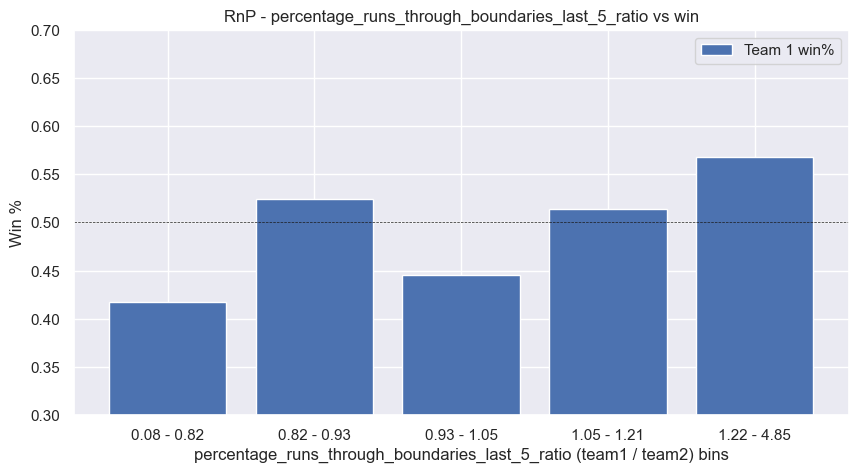

In [99]:
createRnP(train_data, 'percentage_runs_through_boundaries_last_5_ratio')

In [100]:
percentage_runs_through_boundaries_ratio = []
for index, row in test_data_new1.iterrows():
    match_id = row['match id']
    team1_id = row['team1_id']
    team2_id = row['team2_id']
    match_date = row['match_dt']
    
    team1_last_5_matches = get_last_5_matches(team1_id, match_lvl_data, match_date)
    team2_last_5_matches = get_last_5_matches(team2_id, match_lvl_data, match_date)
    
    percentage_team1_runs_through_boundaries = []
    percentage_team2_runs_through_boundaries = []

    for match in team1_last_5_matches:
        percentage_team1_runs_through_boundaries.append(percentage_runs_through_boundaries(match, team1_id, batsman_lvl_data, match_lvl_data ))
    for match in team2_last_5_matches:
        percentage_team2_runs_through_boundaries.append(percentage_runs_through_boundaries(match, team2_id, batsman_lvl_data, match_lvl_data ))
    if len(team1_last_5_matches) == 0 or len(team2_last_5_matches) == 0:
        percentage_runs_through_boundaries_ratio .append(np.nan)
        continue
    percentage_runs_through_boundaries_ratio.append(((sum(percentage_team1_runs_through_boundaries)/len(team1_last_5_matches))+1)/((sum(percentage_team2_runs_through_boundaries)/len(team2_last_5_matches))+1))    

In [101]:
test_data['percentage_runs_through_boundaries_last_5_ratio']=percentage_runs_through_boundaries_ratio

In [102]:
test_data.head()

match id  team1  ...  team_wickets_ratio_last10 percentage_runs_through_boundaries_last_5_ratio
0  9272619   Me Ss  ...  1.111111                   1.012665                                      
1  9086958   Na     ...  1.192308                   0.770530                                      
2  9433654   Gn     ...  0.727273                   0.797044                                      
3  9097248   Ks     ...  1.166667                   1.109240                                      
4  9097234   Ws     ...  0.677419                   1.390499                                      

[5 rows x 32 columns]

# ### 8. team_avg_econ_ratio_last10 <br>
# Ratio of the average economy rate of the top 3 bowlers of a team in the last n games

In [104]:
# Function to find the average economy rate of the top 3 bowlers of a team in the last n games
def avgEconsT3Lastn(player_list, date, n):
    
    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    econ_list = []
    
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl') # getting bowling stats from last n games for each player
        if not df_rel.empty:
            avg_econ = np.nanmean(df_rel['economy']) # Average economy rate for the player
            econ_list.append((player, avg_econ)) # Append the player id and average economy rate as a tuple to the list
    
    # If econ_list is empty, return NaN to indicate no data available
    if not econ_list:
        return np.nan
    
    # Sort the list by average economy rate in ascending order and take the top 3 (lower economy is better)
    top_3_bowlers = sorted(econ_list, key=lambda x: x[1])[:3]
    
    # Calculate the average economy rate of the top 3 bowlers
    avg_econ_top_3 = np.nanmean([e[1] for e in top_3_bowlers])
    
    return avg_econ_top_3

In [105]:
tqdm.pandas() # to use progress_apply

# Training dataset
train_data['team1_avg_econ_top3_last10'] = train_data.progress_apply(lambda x: \
            avgEconsT3Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=10), axis=1)
train_data['team2_avg_econ_top3_last10'] = train_data.progress_apply(lambda x: \
            avgEconsT3Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=10), axis=1)

100%|████████████████████████████████████████████████████████████████████████████████| 948/948 [00:22<00:00, 42.24it/s]


In [106]:
# Calculating the ratio of average economy rates of top 3 bowlers of team1 to team2
train_data['team_avg_econ_ratio_last10'] = (train_data['team1_avg_econ_top3_last10'] + 1) / ((train_data['team2_avg_econ_top3_last10'] + 1)+(train_data['team1_avg_econ_top3_last10'] + 1))
# Dropping intermediate columns
train_data.drop(columns=['team1_avg_econ_top3_last10', 'team2_avg_econ_top3_last10'], inplace=True)

In [107]:
train_data.shape
train_data.tail(2)

(948, 36)

match id  team1  ...  percentage_runs_through_boundaries_last_5_ratio team_avg_econ_ratio_last10
946  9516695   Rn Rs  ...  1.016022                                         0.497954                 
947  9433633   He     ...  2.032184                                         0.472019                 

[2 rows x 36 columns]

slope: 0.55 / 0.47 =  1.15


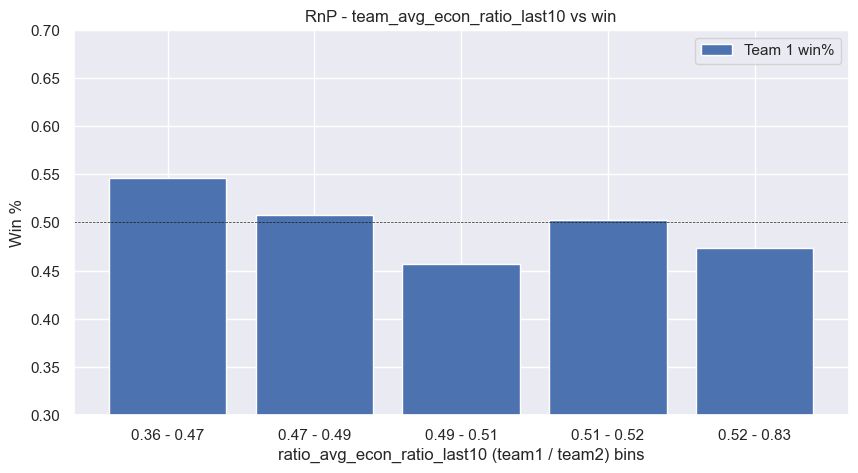

In [108]:
# RnP of team_avg_econ_ratio_last10 computed over the train data. Slope denotes ratio of right most bin to left most bin.
createRnP(train_data, 'team_avg_econ_ratio_last10')

In [109]:
# Test dataset
test_data['team1_avg_econ_top3_last10'] = test_data.progress_apply(lambda x: \
            avgEconsT3Lastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=10), axis=1)
test_data['team2_avg_econ_top3_last10'] = test_data.progress_apply(lambda x: \
            avgEconsT3Lastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=10), axis=1)

100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:05<00:00, 41.01it/s]


In [110]:
# Calculating the ratio of average economy rates of top 3 bowlers of team1 to team2
test_data['team_avg_econ_ratio_last10'] = (test_data['team1_avg_econ_top3_last10'] + 1) / ((test_data['team2_avg_econ_top3_last10'] + 1)+(test_data['team1_avg_econ_top3_last10'] + 1))

# Dropping intermediate columns
test_data.drop(columns=['team1_avg_econ_top3_last10', 'team2_avg_econ_top3_last10'], inplace=True)

In [111]:
test_data.shape
test_data.head(2)

(207, 33)

match id  team1  ...  percentage_runs_through_boundaries_last_5_ratio team_avg_econ_ratio_last10
0  9272619   Me Ss  ...  1.012665                                         0.435788                 
1  9086958   Na     ...  0.770530                                         0.485785                 

[2 rows x 33 columns]

# ### 9. runs_through_extras_last_5_ratio <br>
# Ratio of extras conceded in last 5 games

In [113]:
def extra_runs_given(match_id, team_id, bowler_df, train_df):
    match_data = train_df[train_df['match id'] == match_id]
    
    if len(match_data) == 0:
        print(f"No match data found for Match ID: {match_id}")
        return 0
    
    if match_data.iloc[0]['team1_id'] == team_id:
        team_roster_ids = match_data.iloc[0]['team1_roster_ids'].split(':')
    elif match_data.iloc[0]['team2_id'] == team_id:
        team_roster_ids = match_data.iloc[0]['team2_roster_ids'].split(':')
    else:
        print(f"Team ID {team_id} not found in Match ID {match_id}")
        return 0
    
    team_roster_ids = [id.split('.')[0] for id in team_roster_ids]
    
    match_bowler_data = bowler_df[bowler_df['match id'] == match_id].copy()
    match_bowler_data['bowler_id'] = match_bowler_data['bowler_id'].astype(str).apply(lambda x: x.split('.')[0])
    
    team_bowlers = match_bowler_data[match_bowler_data['bowler_id'].isin(team_roster_ids)].copy()
    
    team_bowlers.loc[:, 'wides'] = team_bowlers['wides'].fillna(0)
    team_bowlers.loc[:, 'noballs'] = team_bowlers['noballs'].fillna(0)
    if len(team_bowlers)<2:
        return 1
    
    runs_through_extras = team_bowlers['wides'].sum() + team_bowlers['noballs'].sum()
    
    return runs_through_extras

In [114]:
runs_through_extras_ratio = []
for index, row in train_data.iterrows():
    match_id = row['match id']
    team1_id = row['team1_id']
    team2_id = row['team2_id']
    match_date = row['match_dt']
    
    team1_last_5_matches = get_last_5_matches(team1_id, match_lvl_data, match_date)
    team2_last_5_matches = get_last_5_matches(team2_id, match_lvl_data, match_date)
    
    team1_runs_through_extras = []
    team2_runs_through_extras = []

    for match in team1_last_5_matches:
        team1_runs_through_extras.append(extra_runs_given(match, team1_id, bowler_lvl_data, match_lvl_data ))
    for match in team2_last_5_matches:
        team2_runs_through_extras.append(extra_runs_given(match, team2_id, bowler_lvl_data, match_lvl_data ))
    if (len(team1_last_5_matches)==0 and len(team2_last_5_matches)==0):
        runs_through_extras_ratio.append(0.5)
        continue
    elif len(team1_last_5_matches) == 0 :
        runs_through_extras_ratio.append(row['percent_won_first_match'])
        continue
    elif (len(team2_last_5_matches) == 0 ):
        runs_through_extras_ratio.append(1-row['percent_won_first_match'])
        continue
    
    runs_through_extras_ratio.append(((sum(team1_runs_through_extras)/len(team1_last_5_matches))*10+1)/(((sum(team2_runs_through_extras)/len(team2_last_5_matches))*10+1)+((sum(team1_runs_through_extras)/len(team1_last_5_matches))*10+1)))

In [115]:
train_data['runs_through_extras_last_5_ratio']=runs_through_extras_ratio

In [116]:
train_data.head()

match id     team1  ...  team_avg_econ_ratio_last10 runs_through_extras_last_5_ratio
0  9331181   Ba        ...  0.466405                    0.653846                       
1  8797060   Ed        ...  0.496062                    0.283784                       
2  9433269   We        ...  0.478955                    0.642857                       
3  9587073   Ga An Ws  ...  0.465336                    0.532787                       
4  9516457   Pb Ks     ...  0.512617                    0.612500                       

[5 rows x 37 columns]

In [117]:
createRnP(train_data, 'runs_through_extras_last_5_ratio')

slope: 0.52 / 0.46 =  1.14


In [118]:
runs_through_extras_ratio = []
for index, row in test_data.iterrows():
    match_id = row['match id']
    team1_id = row['team1_id']
    team2_id = row['team2_id']
    match_date = row['match_dt']
    
    team1_last_5_matches = get_last_5_matches(team1_id, match_lvl_data, match_date)
    team2_last_5_matches = get_last_5_matches(team2_id, match_lvl_data, match_date)
    
    team1_runs_through_extras = []
    team2_runs_through_extras = []

    for match in team1_last_5_matches:
        team1_runs_through_extras.append(extra_runs_given(match, team1_id, bowler_lvl_data, match_lvl_data ))
    for match in team2_last_5_matches:
        team2_runs_through_extras.append(extra_runs_given(match, team2_id, bowler_lvl_data, match_lvl_data ))
    if (len(team1_last_5_matches)==0 and len(team2_last_5_matches)==0):
        runs_through_extras_ratio.append(0.5)
        continue
    elif len(team1_last_5_matches) == 0 :
        runs_through_extras_ratio.append(row['percent_won_first_match'])
        continue
    elif (len(team2_last_5_matches) == 0 ):
        runs_through_extras_ratio.append(1-row['percent_won_first_match'])
        continue
    
    runs_through_extras_ratio.append(((sum(team1_runs_through_extras)/len(team1_last_5_matches))*10+1)/(((sum(team2_runs_through_extras)/len(team2_last_5_matches))*10+1)+((sum(team1_runs_through_extras)/len(team1_last_5_matches))*10+1)))    

In [119]:
test_data['runs_through_extras_last_5_ratio']=runs_through_extras_ratio

In [120]:
test_data.head()

match id  team1  ...  team_avg_econ_ratio_last10 runs_through_extras_last_5_ratio
0  9272619   Me Ss  ...  0.435788                    0.264706                       
1  9086958   Na     ...  0.485785                    0.406977                       
2  9433654   Gn     ...  0.514200                    0.528571                       
3  9097248   Ks     ...  0.532242                    0.602941                       
4  9097234   Ws     ...  0.521423                    0.472973                       

[5 rows x 34 columns]

# ### 10. bowling_srrate_ratio_last_10 <br>
# Bowling strike rate ratio

In [122]:
def bowling_strike_rate(match_id, team_id, train_df):
    match_data = train_df[train_df['match id'] == match_id]
    
    if len(match_data) == 0:
        print(f"No match data found for Match ID: {match_id}")
        return 0
    
    if match_data.iloc[0]['team1_id'] == team_id:
        if match_data.iloc[0]['toss_winner_01']==0 and match_data.iloc[0]['toss_decision_01']==1 :
            if match_data.iloc[0]['inning2_wickets']==0:
                bowl_strike_rate=match_data.iloc[0]['inning2_runs']
            else:
                bowl_strike_rate=match_data.iloc[0]['inning2_runs']/match_data.iloc[0]['inning2_wickets']
        elif match_data.iloc[0]['toss_winner_01']==0 and match_data.iloc[0]['toss_decision_01']==0 :
            if match_data.iloc[0]['inning1_wickets']==0:
                bowl_strike_rate=match_data.iloc[0]['inning1_runs']
            else:
                bowl_strike_rate=match_data.iloc[0]['inning1_runs']/match_data.iloc[0]['inning1_wickets']
        elif match_data.iloc[0]['toss_winner_01']==1 and match_data.iloc[0]['toss_decision_01']==0 :
            if match_data.iloc[0]['inning2_wickets']==0:
                bowl_strike_rate=match_data.iloc[0]['inning2_runs']
            else:
                bowl_strike_rate=match_data.iloc[0]['inning2_runs']/match_data.iloc[0]['inning2_wickets']
        else:
            if match_data.iloc[0]['inning1_wickets']==0:
                bowl_strike_rate=match_data.iloc[0]['inning1_runs']
            else:
                bowl_strike_rate=match_data.iloc[0]['inning1_runs']/match_data.iloc[0]['inning1_wickets']
    
    elif match_data.iloc[0]['team2_id'] == team_id:
        if match_data.iloc[0]['toss_winner_01']==0 and match_data.iloc[0]['toss_decision_01']==1 :
            if match_data.iloc[0]['inning1_wickets']==0:
                bowl_strike_rate=match_data.iloc[0]['inning1_runs']
            else:
                bowl_strike_rate=match_data.iloc[0]['inning1_runs']/match_data.iloc[0]['inning1_wickets']
        elif match_data.iloc[0]['toss_winner_01']==0 and match_data.iloc[0]['toss_decision_01']==0 :
            if match_data.iloc[0]['inning2_wickets']==0:
                bowl_strike_rate=match_data.iloc[0]['inning2_runs']
            else:
                bowl_strike_rate=match_data.iloc[0]['inning2_runs']/match_data.iloc[0]['inning2_wickets']
        elif match_data.iloc[0]['toss_winner_01']==1 and match_data.iloc[0]['toss_decision_01']==0 :
            if match_data.iloc[0]['inning1_wickets']==0:
                bowl_strike_rate=match_data.iloc[0]['inning1_runs']
            else:
                bowl_strike_rate=match_data.iloc[0]['inning1_runs']/match_data.iloc[0]['inning1_wickets']
        else:
            if match_data.iloc[0]['inning2_wickets']==0:
                bowl_strike_rate=match_data.iloc[0]['inning2_runs']
            else:
                bowl_strike_rate=match_data.iloc[0]['inning2_runs']/match_data.iloc[0]['inning2_wickets']
       
    else:
        print(f"Team ID {team_id} not found in Match ID {match_id}")
        return 0
    
    return bowl_strike_rate

In [123]:
bowling_strike_rate_ratio = []
for index, row in train_data.iterrows():
    match_id = row['match id']
    team1_id = row['team1_id']
    team2_id = row['team2_id']
    match_date = row['match_dt']
    
    team1_last_10_matches = get_last_10_matches(team1_id, match_lvl_data, match_date)
    team2_last_10_matches = get_last_10_matches(team2_id, match_lvl_data, match_date)
    
    team1_bowling_strike_rate = []
    team2_bowling_strike_rate = []

    for match in team1_last_10_matches:
        team1_bowling_strike_rate.append(bowling_strike_rate(match, team1_id, match_lvl_data))
    for match in team2_last_10_matches:
        team2_bowling_strike_rate.append(bowling_strike_rate(match, team2_id, match_lvl_data))
    if (len(team1_last_5_matches)==0 or len(team2_last_5_matches)==0):
        bowling_strike_rate_ratio.append(np.NaN)
    
    else:
        bowling_strike_rate_ratio.append((((sum(team1_bowling_strike_rate)/len(team1_last_5_matches))+1)/(((sum(team2_bowling_strike_rate)/len(team2_last_5_matches))+1))))    

In [124]:
train_data['bowling_srrate_ratio_last_10']=bowling_strike_rate_ratio

In [125]:
createRnP(train_data, 'bowling_srrate_ratio_last_10')

slope: 0.51 / 0.43 =  1.19


In [126]:
bowling_strike_rate_ratio = []
for index, row in test_data.iterrows():
    match_id = row['match id']
    team1_id = row['team1_id']
    team2_id = row['team2_id']
    match_date = row['match_dt']
    
    team1_last_10_matches = get_last_10_matches(team1_id, match_lvl_data, match_date)
    team2_last_10_matches = get_last_10_matches(team2_id, match_lvl_data, match_date)
    
    team1_bowling_strike_rate = []
    team2_bowling_strike_rate = []

    for match in team1_last_10_matches:
        team1_bowling_strike_rate.append(bowling_strike_rate(match, team1_id, match_lvl_data))
    for match in team2_last_10_matches:
        team2_bowling_strike_rate.append(bowling_strike_rate(match, team2_id, match_lvl_data))
    if (len(team1_last_5_matches)==0 or len(team2_last_5_matches)==0):
        bowling_strike_rate_ratio.append(np.NaN)
    
    else:
        bowling_strike_rate_ratio.append((((sum(team1_bowling_strike_rate)/len(team1_last_5_matches))+1)/(((sum(team2_bowling_strike_rate)/len(team2_last_5_matches))+1))))    

In [127]:
test_data['bowling_srrate_ratio_last_10']=bowling_strike_rate_ratio

# ### 11. weighted wins <br>
# ratio of weighted average of wins for teams, normalizing win amounts by wickets and runs

In [129]:
def wins(date, team_id):
    
    # filter out games with either team1/2_id as input ground_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
    df = match_lvl_data[(match_lvl_data['match_dt']<date)].sort_values(by='match_dt', ascending=False)
    df_rel1 = df[df['team1_id'] == team_id] 
    df_rel2 = df[df['team2_id'] == team_id]
    df_rel =  pd.concat([df_rel1, df_rel2], axis = 0)
    if(df_rel.shape[0] == 0):
        return float('nan')
    df1 = df_rel[df_rel['by'] == 'wickets']
    df2 = df_rel[df_rel['by'] == 'runs']
    df1['win amount'] = (df1['win amount']/df1['win amount'].max())
    df2['win amount'] = (df2['win amount']/df2['win amount'].max()) 
    final_df = pd.concat([df1, df2], axis = 0)
    return final_df['win amount'].sum() / final_df.shape[0]

In [130]:
train_data['weighted wins'] = train_data.progress_apply(lambda x: \
            (wins(x['match_dt'], x['team1_id'])/wins(x['match_dt'], x['team2_id'])), axis=1)

100%|████████████████████████████████████████████████████████████████████████████████| 948/948 [00:13<00:00, 70.69it/s]


In [131]:
test_data['weighted wins'] = test_data.progress_apply(lambda x: \
            (wins(x['match_dt'], x['team1_id'])/wins(x['match_dt'], x['team2_id'])), axis=1)

100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:02<00:00, 69.87it/s]


In [132]:
createRnP(train_data, 'weighted wins')

slope: 0.51 / 0.46 =  1.1


# ### 12. day_night_match <br>
# Ratio of teams performance in Day/Night Conditions

In [134]:
def get_last_5_matches_with_lighting(team_id, match_date, lighting_condition, match2):
    team_matches = match2[((match2['team1_id'] == team_id) | (match2['team2_id'] == team_id)) & 
                          (match2['match_dt'] < match_date) & 
                          (match2['lighting'] == lighting_condition)]
    team_matches = team_matches.sort_values(by='match_dt', ascending=False).head(5)
    return team_matches

In [135]:
def calculate_win_percentage(team_id, matches):
    if len(matches) == 0:
        return np.NaN
    win_count = 0
    for _, match in matches.iterrows():
        if (match['team1_id'] == team_id and match['winner_id'] == match['team1_id']) or \
           (match['team2_id'] == team_id and match['winner_id'] == match['team2_id']):
            win_count += 1
    win_percentage = win_count / len(matches)
    return win_percentage

In [136]:
day_night_ratios=[]
for index, row in train_data.iterrows():
    match_id = row['match id']
    team1_id = row['team1_id']
    team2_id = row['team2_id']
    match_date = row['match_dt']
    lighting_condition = row['lighting']
    
    team1_matches = get_last_5_matches_with_lighting(team1_id, match_date, lighting_condition, match_lvl_data)
    team2_matches = get_last_5_matches_with_lighting(team2_id, match_date, lighting_condition, match_lvl_data)
    
    team1_win_percentage = calculate_win_percentage(team1_id, team1_matches)
    team2_win_percentage = calculate_win_percentage(team2_id, team2_matches)
    
    # First match logic
    if (len(team1_matches) == 0) or (len(team2_matches) == 0):
        ratio = 0.5
        
    elif(len(team1_matches)==0):
        ratio = row['percent_won_first_match']
      
    elif(len(team2_matches)==0):
        ratio = 1-row['percent_won_first_match']  
       
    else:
        ratio = ((team1_win_percentage * 50) + 1) / (((team2_win_percentage * 50) + 1)+((team1_win_percentage * 50) + 1))
    
    day_night_ratios.append(ratio)

train_data['day_night_match'] = day_night_ratios

In [137]:
train_data['day_night_match'] = day_night_ratios

In [138]:
train_data.head()

match id     team1  team1_id  ... bowling_srrate_ratio_last_10 weighted wins  day_night_match
0  9331181   Ba        11283     ...  1.090894                     0.833459      0.500000       
1  8797060   Ed        20        ...  0.874017                     1.248160      0.019231       
2  9433269   We        10576     ...  1.392315                     1.315101      0.261905       
3  9587073   Ga An Ws  36084     ...  0.761443                     0.973109      0.291667       
4  9516457   Pb Ks     30407     ...  1.253476                     0.847589      0.500000       

[5 rows x 40 columns]

slope: 0.54 / 0.43 =  1.25


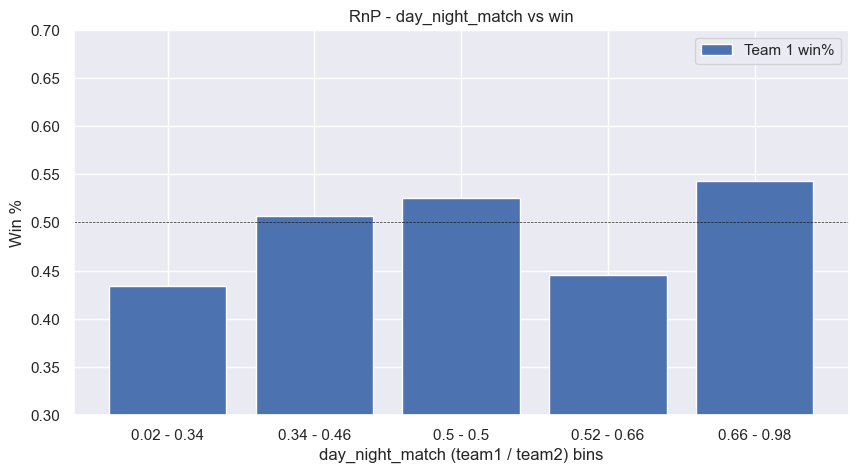

In [139]:
createRnP(train_data, 'day_night_match')

In [140]:
day_night_ratios=[]
for index, row in test_data.iterrows():
    match_id = row['match id']
    team1_id = row['team1_id']
    team2_id = row['team2_id']
    match_date = row['match_dt']
    lighting_condition = row['lighting']
    
    team1_matches = get_last_5_matches_with_lighting(team1_id, match_date, lighting_condition, match_lvl_data)
    team2_matches = get_last_5_matches_with_lighting(team2_id, match_date, lighting_condition, match_lvl_data)
    
    team1_win_percentage = calculate_win_percentage(team1_id, team1_matches)
    team2_win_percentage = calculate_win_percentage(team2_id, team2_matches)
    
    # First match logic
    if (len(team1_matches) == 0) or (len(team2_matches) == 0):
        ratio = 0.5
        
    elif(len(team1_matches)==0):
        ratio = row['percent_won_first_match']
      
    elif(len(team2_matches)==0):
        ratio = 1-row['percent_won_first_match']  
       
    else:
        ratio = ((team1_win_percentage * 50) + 1) / (((team2_win_percentage * 50) + 1)+((team1_win_percentage * 50) + 1))
    
    day_night_ratios.append(ratio)

test_data['day_night_match'] = day_night_ratios

In [141]:
test_data.head()

match id  team1  team1_id  ... bowling_srrate_ratio_last_10 weighted wins  day_night_match
0  9272619   Me Ss  33949     ...  0.620334                     1.102122      0.500000       
1  9086958   Na     209       ...  0.920868                     1.348814      0.500000       
2  9433654   Gn     7573      ...  1.721480                     1.094012      0.338710       
3  9097248   Ks     22784     ...  1.098238                     1.290962      0.211538       
4  9097234   Ws     23841     ...  1.735790                     1.000000      0.500000       

[5 rows x 37 columns]

# ### 13. batting_bowling_win_ratio <br>
# Ratio of win percentage of teams Batting/bowling first in last 10 games

In [143]:
# Function to get the last 5 matches where a team batted first
def get_last_10_matches_batting_first(team_id, match_date, match_data):
    team_matches = match_data[((match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)) & 
                              (match_data['match_dt'] < match_date) & 
                              ((match_data['team1_id'] == team_id) & (match_data['toss_decision_01'] == 1) |
                               (match_data['team2_id'] == team_id) & (match_data['toss_decision_01'] == 1))]
    team_matches = team_matches.sort_values(by='match_dt', ascending=False).head(10)
    return team_matches

In [144]:
# Function to get the last 5 matches where a team bowled first
def get_last_10_matches_bowling_first(team_id, match_date, match_data):
    team_matches = match_data[((match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)) & 
                              (match_data['match_dt'] < match_date) & 
                              ((match_data['team1_id'] == team_id) & (match_data['toss_decision_01'] == 0) |
                               (match_data['team2_id'] == team_id) & (match_data['toss_decision_01'] == 0))]
    team_matches = team_matches.sort_values(by='match_dt', ascending=False).head(10)
    return team_matches

In [145]:
# Function to calculate win percentage
def calculate_win_percentage(team_id, matches):
    if len(matches) == 0:
        return np.NaN
    win_count = 0
    for _, match in matches.iterrows():
        if (match['team1_id'] == team_id and match['winner_id'] == match['team1_id']) or \
           (match['team2_id'] == team_id and match['winner_id'] == match['team2_id']):
            win_count += 1
    win_percentage = win_count / len(matches)
    return win_percentage

In [146]:
# Initialize the new feature list
batting_bowling_ratios = []

for index, row in train_data.iterrows():
    match_id = row['match id']
    team1_id = row['team1_id']
    team2_id = row['team2_id']
    match_date = row['match_dt']
    toss_winner_01 = row['toss_winner_01']  # 0 if team1 won the toss, 1 if team2 won the toss
    toss_decision_01 = row['toss_decision_01']  # 1 if batting is chosen, 0 if bowling is chosen
    
    # Determine team IDs of toss winner and loser
    if toss_winner_01 == 0:
        toss_winner_id = team1_id
        toss_loser_id = team2_id
    else:
        toss_winner_id = team2_id
        toss_loser_id = team1_id

    if toss_decision_01 == 1:  # Toss winner chooses to bat
        batting_first_team_id = toss_winner_id
        bowling_first_team_id = toss_loser_id
    else:  # Toss winner chooses to bowl
        batting_first_team_id = toss_loser_id
        bowling_first_team_id = toss_winner_id

    # Get last 5 matches for each team
    batting_first_matches = get_last_10_matches_batting_first(batting_first_team_id, match_date, match_lvl_data)
    bowling_first_matches = get_last_10_matches_bowling_first(bowling_first_team_id, match_date, match_lvl_data)
    
    # Calculate win percentages
    batting_first_win_percentage = calculate_win_percentage(batting_first_team_id, batting_first_matches)
    bowling_first_win_percentage = calculate_win_percentage(bowling_first_team_id, bowling_first_matches)
    
    # First match logic
    if (len(batting_first_matches) == 0) or (len(bowling_first_matches) == 0):
        ratio = 0.5
    elif len(batting_first_matches) == 0:
        ratio = row['percent_won_first_match']
    elif len(bowling_first_matches) == 0:
        ratio = 1 - row['percent_won_first_match']
    else:
        ratio = ((batting_first_win_percentage * 50) + 1) / ((bowling_first_win_percentage * 50) + 1)
    
    batting_bowling_ratios.append(ratio)

# Add the new feature to the train_data dataframe
train_data['batting_bowling_win_ratio'] = batting_bowling_ratios

In [147]:
train_data.head()

match id     team1  team1_id  ... weighted wins day_night_match  batting_bowling_win_ratio
0  9331181   Ba        11283     ...  0.833459      0.500000        0.903475                 
1  8797060   Ed        20        ...  1.248160      0.019231        2.428571                 
2  9433269   We        10576     ...  1.315101      0.261905        1.000000                 
3  9587073   Ga An Ws  36084     ...  0.973109      0.291667        1.107527                 
4  9516457   Pb Ks     30407     ...  0.847589      0.500000        0.393204                 

[5 rows x 41 columns]

slope: 0.51 / 0.45 =  1.14


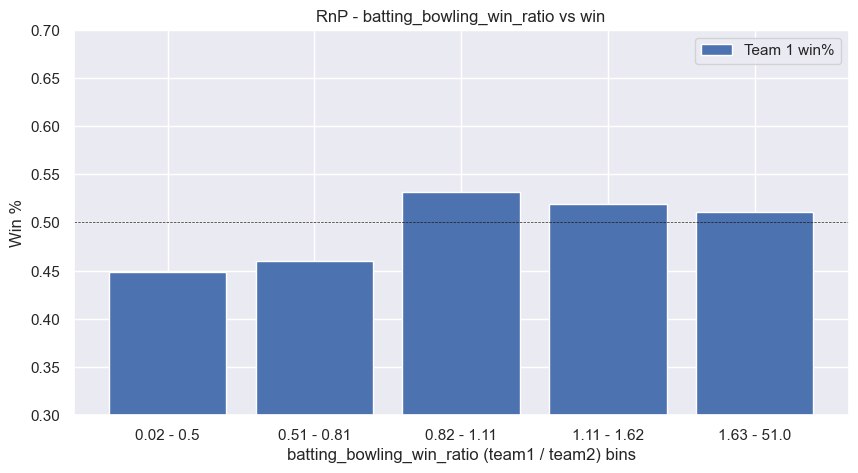

In [148]:
createRnP(train_data, 'batting_bowling_win_ratio')

In [149]:
# Initialize the new feature list
batting_bowling_ratios = []

for index, row in test_data.iterrows():
    match_id = row['match id']
    team1_id = row['team1_id']
    team2_id = row['team2_id']
    match_date = row['match_dt']
    toss_winner_01 = row['toss_winner_01']  # 0 if team1 won the toss, 1 if team2 won the toss
    toss_decision_01 = row['toss_decision_01']  # 1 if batting is chosen, 0 if bowling is chosen
    
    # Determine team IDs of toss winner and loser
    if toss_winner_01 == 0:
        toss_winner_id = team1_id
        toss_loser_id = team2_id
    else:
        toss_winner_id = team2_id
        toss_loser_id = team1_id

    if toss_decision_01 == 1:  # Toss winner chooses to bat
        batting_first_team_id = toss_winner_id
        bowling_first_team_id = toss_loser_id
    else:  # Toss winner chooses to bowl
        batting_first_team_id = toss_loser_id
        bowling_first_team_id = toss_winner_id

    # Get last 5 matches for each team
    batting_first_matches = get_last_10_matches_batting_first(batting_first_team_id, match_date, match_lvl_data)
    bowling_first_matches = get_last_10_matches_bowling_first(bowling_first_team_id, match_date, match_lvl_data)
    
    # Calculate win percentages
    batting_first_win_percentage = calculate_win_percentage(batting_first_team_id, batting_first_matches)
    bowling_first_win_percentage = calculate_win_percentage(bowling_first_team_id, bowling_first_matches)
    
    # First match logic
    if (len(batting_first_matches) == 0) or (len(bowling_first_matches) == 0):
        ratio = 0.5
    elif len(batting_first_matches) == 0:
        ratio = row['percent_won_first_match']
    elif len(bowling_first_matches) == 0:
        ratio = 1 - row['percent_won_first_match']
    else:
        ratio = ((batting_first_win_percentage * 50) + 1) / ((bowling_first_win_percentage * 50) + 1)
    
    batting_bowling_ratios.append(ratio)

# Add the new feature to the train_data dataframe
test_data['batting_bowling_win_ratio'] = batting_bowling_ratios

# ### 14. ratio_avg_runs_last15 <br>
# Ratio of average runs of both teams in the last 15 matches

In [151]:
def teamAvgRunsLastn(team_id, date, n):
   
    df_rel = match_lvl_data[(match_lvl_data['match_dt'] < date) & \
                            ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id))] \
                            .sort_values(by='match_dt', ascending=False).head(n)
    
    df_rel = pd.concat([df_rel[df_rel['team1_id'] == team_id][['inning1_runs']].rename(columns={'inning1_runs': 'runs'}),
                        df_rel[df_rel['team2_id'] == team_id][['inning2_runs']].rename(columns={'inning2_runs': 'runs'})])
    
    return df_rel['runs'].mean()

In [152]:
# Compute average runs scored by team1 in their last 15 games for train data.
train_data['team1only_avg_runs_last15'] = train_data.progress_apply(
    lambda x: teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)


100%|███████████████████████████████████████████████████████████████████████████████| 948/948 [00:04<00:00, 218.32it/s]


In [153]:
# Compute average runs scored by team2 in their last 15 games for train data.
train_data['team2only_avg_runs_last15'] = train_data.progress_apply(
    lambda x: teamAvgRunsLastn(x['team2_id'], x['match_dt'], 15), axis=1)


100%|███████████████████████████████████████████████████████████████████████████████| 948/948 [00:04<00:00, 220.71it/s]


In [154]:

# Calculate the ratio of average runs
train_data['ratio_avg_runs_last15'] = train_data['team1only_avg_runs_last15'] / train_data['team2only_avg_runs_last15']

# Handle infinite values resulting from division by zero
train_data['ratio_avg_runs_last15'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\priti\AppData\Local\Temp\ipykernel_22400\3138178731.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['ratio_avg_runs_last15'].replace([np.inf, -np.inf], np.nan, inplace=True)


slope: 0.56 / 0.46 =  1.22


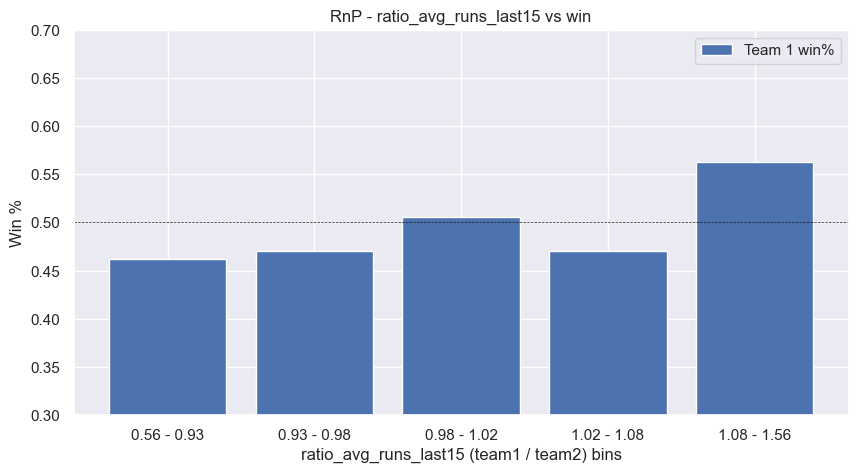

In [155]:
createRnP(train_data, 'ratio_avg_runs_last15')

In [156]:
# Compute average runs scored by team1 in their last 15 games for train data.
test_data['team1only_avg_runs_last15'] = test_data.progress_apply(
    lambda x: teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)


100%|███████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 216.05it/s]


In [157]:
# Compute average runs scored by team2 in their last 15 games for train data.
test_data['team2only_avg_runs_last15'] = test_data.progress_apply(
    lambda x: teamAvgRunsLastn(x['team2_id'], x['match_dt'], 15), axis=1)


100%|███████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 217.17it/s]


In [158]:
# Calculate the ratio of average runs
test_data['ratio_avg_runs_last15'] = test_data['team1only_avg_runs_last15'] / test_data['team2only_avg_runs_last15']

# Handle infinite values resulting from division by zero
test_data['ratio_avg_runs_last15'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\priti\AppData\Local\Temp\ipykernel_22400\4294455487.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['ratio_avg_runs_last15'].replace([np.inf, -np.inf], np.nan, inplace=True)


#### Selecting relevant columns

In [160]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.feature_selection import mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor

# We Combined Mutual Information with Multicollinearity Checks to get the top features and used it below. 
# Commented the not so important features.

In [162]:
X,y = train_data[[#'toss_winner_01',
                  #'toss_decision_01',
                  'team_count_50runs_last15',
                  'team_winp_last5',
                  #'team1only_avg_runs_last15',
                  'team1_winp_team2_last15',
                  'ground_avg_runs_last15',
                  #'team_avg_Econ_last10',
                  #'pitch condition',
                  #'percentage_dot_balls_bowled_last_5',
                  'team_wickets_ratio_last10',
                  #'percentage_runs_through_boundaries_last_5_ratio',
                  'team_runs_ratio_last10',
                  'ratio_avg_runs_last15',
                  'team_srrate_ratio_last10', 
                  #'team_avg_econ_ratio_last10', 
                  #'runs_through_extras_last_5_ratio', 
                  #'ratio_avg_runs_last15',
                  'bowling_srrate_ratio_last_10', 
                  #'day_night_match',
                  #'batting_bowling_win_ratio'
                  'weighted wins']], train_data['winner_01']

In [163]:
X_test = test_data[X.columns.tolist()]

#### Imputation

In [165]:
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# We divided the dataset into three parts: training, feature selection, and testing. 
# This approach allows for unbiased feature selection and parameter tuning, leading to a more accurate and generalizable model.

In [167]:
# # Split the data into training, feature selection, and testing datasets
# X_train_full, X_feature_selection, y_train_full, y_feature_selection = train_test_split(
#     X_imputed_df, y, test_size=0.2, random_state=42
# )
# X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [168]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#### 1. Using KNN Imputer

In [170]:
# # Initialize the KNNImputer
# imputer = KNNImputer(n_neighbors=5)

# # Fit and transform the training features
# X_imputed = imputer.fit_transform(X)

# # Transform the test features
# X_test_imputed = imputer.transform(X_test[feature_columns])

In [171]:
# # Convert the imputed arrays back to DataFrames
# X_imputed_df = pd.DataFrame(X_imputed, columns=feature_columns)
# X_test_imputed_df = pd.DataFrame(X_test_imputed, columns=feature_columns)

# # Add 'team1_id', 'team2_id', 'match id' back to X_test_imputed_df
# X_test_imputed_df[id_columns] = X_test[id_columns].reset_index(drop=True)

In [172]:
# # Verify if there are any remaining missing values
# print("Training data missing values after imputation:")
# print(X_imputed_df.isna().sum())

# print("Test data missing values after imputation:")
# print(X_test_imputed_df.isna().sum())

In [173]:
# X_imputed_df.head()

#### 2. Replacing Nans with Zeros

In [175]:
# Identify columns with missing values in X_train
X_train_nans = X_train.isna().sum().reset_index()
print("Columns with missing values in X_train:")
print(X_train_nans[X_train_nans[0] != 0])

# Identify columns with missing values in X_test
X_test_nans = X_test.isna().sum().reset_index()
print("Columns with missing values in X_test:")
print(X_test_nans[X_test_nans[0] != 0])

# Impute missing values (replace NaNs with 0)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
X_val.fillna(0,inplace=True)
# Confirm no more missing values in X_train
X_train_nans_after = X_train.isna().sum().reset_index()
print("Columns with missing values in X_train after imputation:")
print(X_train_nans_after[X_train_nans_after[0] != 0])

# Confirm no more missing values in X_test
X_test_nans_after = X_test.isna().sum().reset_index()
print("Columns with missing values in X_test after imputation:")
print(X_test_nans_after[X_test_nans_after[0] != 0])

Columns with missing values in X_train:
                    index   0
3  ground_avg_runs_last15  41
6  ratio_avg_runs_last15   29
9  weighted wins           29
Columns with missing values in X_test:
                    index   0
3  ground_avg_runs_last15  10
6  ratio_avg_runs_last15   1 
9  weighted wins           1 
Columns with missing values in X_train after imputation:
Empty DataFrame
Columns: [index, 0]
Index: []
Columns with missing values in X_test after imputation:
Empty DataFrame
Columns: [index, 0]
Index: []


C:\Users\priti\AppData\Local\Temp\ipykernel_22400\3975344072.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.fillna(0, inplace=True)


### Stats

In [177]:
# Calculate and print descriptive statistics for each specified feature
features = [
    #'toss_winner_01',
                  #'toss_decision_01',
                  'team_count_50runs_last15',
                  'team_winp_last5',
                  #'team1only_avg_runs_last15',
                  'team1_winp_team2_last15',
                  'ground_avg_runs_last15',
                  #'team_avg_Econ_last10',
                  #'pitch condition',
                  #'percentage_dot_balls_bowled_last_5',
                  'team_wickets_ratio_last10',
                  #'percentage_runs_through_boundaries_last_5_ratio',
                  'team_runs_ratio_last10',
                  'ratio_avg_runs_last15',
                  'team_srrate_ratio_last10', 
                  #'team_avg_econ_ratio_last10', 
                  #'runs_through_extras_last_5_ratio', 
                  #'ratio_avg_runs_last15',
                  'bowling_srrate_ratio_last_10', 
                  #'day_night_match',
                  #'batting_bowling_win_ratio'
                  'weighted wins'
]

# Print descriptive statistics for each feature
for feature in features:
    print(f"Descriptive statistics for {feature}:")
    print(X_train[feature].describe(), "\n")
    print(X_test[feature].describe(), "\n")
    print(X_val[feature].describe(), "\n")

Descriptive statistics for team_count_50runs_last15:
count    758.000000
mean     1.201000  
std      1.038241  
min      0.083333  
25%      0.687500  
50%      1.000000  
75%      1.363636  
max      11.000000 
Name: team_count_50runs_last15, dtype: float64 

count    207.000000
mean     1.074161  
std      0.721556  
min      0.000000  
25%      0.600000  
50%      0.944444  
75%      1.381944  
max      4.250000  
Name: team_count_50runs_last15, dtype: float64 

count    190.000000
mean     1.208992  
std      0.884054  
min      0.111111  
25%      0.671053  
50%      1.000000  
75%      1.500000  
max      7.000000  
Name: team_count_50runs_last15, dtype: float64 

Descriptive statistics for team_winp_last5:
count    758.000000
mean     4.764698  
std      15.588280 
min      0.009901  
25%      0.512195  
50%      1.000000  
75%      1.952381  
max      101.000000
Name: team_winp_last5, dtype: float64 

count    207.000000
mean     3.239025  
std      11.788742 
min      0.00990

### Feature Selection

#### 1. Combining Mutual Information with Multicollinearity Checks

# We Combined Mutual Information with Multicollinearity Checks to get the top features and used it. 
# Commented the not so important features while selecting relevant columns.

In [181]:
# # Step 2: Feature Selection Combining Mutual Information with Multicollinearity Checks
# mutual_info = mutual_info_classif(X_feature_selection, y_feature_selection)
# mi_series = pd.Series(mutual_info, index=feature_columns)
# top_features_mi = mi_series.nlargest(10).index.tolist()

In [182]:
# def calculate_vif(X):
#     vif_data = pd.DataFrame()
#     vif_data["feature"] = X.columns
#     vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
#     return vif_data

In [183]:
# # Adjust the threshold to ensure we have at least 10 features
# vif_threshold = 10
# vif_filtered_features = []

# while len(vif_filtered_features) < 10 and vif_threshold >= 1:
#     vif_data = calculate_vif(X_feature_selection[top_features_mi])
#     vif_filtered_features = vif_data[vif_data["VIF"] < vif_threshold]["feature"].tolist()
#     vif_threshold -= 1

# # If fewer than 10 features are still present, forcefully select top 10 features regardless of VIF
# if len(vif_filtered_features) < 10:
#     vif_filtered_features = vif_data.sort_values(by="VIF").head(10)["feature"].tolist()

# print(f"Selected features: {vif_filtered_features}")

#### 2. Combining RFE and Cross-Validation

# We tried Combining RFE and Cross-Validation but results were not nice. 

In [186]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

In [187]:
# # Step 2: Feature Selection with RFE and Cross-Validation
# from sklearn.model_selection import StratifiedKFold

# # Define the XGBoost model
# xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# # Define RFE with cross-validation
# n_features_to_select = 10
# rfe = RFE(estimator=xgb_model, n_features_to_select=n_features_to_select, step=1)
# rfe = rfe.fit(X_scaled_df, y)

# # Get the selected features
# selected_features = X_scaled_df.columns[rfe.support_].tolist()
# print(f"Selected Features: {selected_features}")

In [188]:
# # Perform cross-validation to evaluate the performance of the selected features
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(xgb_model, X_scaled_df[selected_features], y, cv=cv, scoring='accuracy')
# print(f"Cross-Validation Accuracy Scores: {scores}")
# print(f"Mean CV Accuracy: {scores.mean()}")

## Model

In [190]:
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
from catboost import CatBoostClassifier
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### 1. XGB

In [192]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# These paramentes below are taken by trying with both BayesianOptimization and GridSearchCV and then choosing the best one

In [194]:
# User-defined parameters
algo_name = 'XGBClassifier'
is_ensemble = 'no'
n_trees = 13
depth = 2
lr = 0.17

##### Initialize and train the model

In [196]:
clf_xgb = XGBClassifier(
    n_estimators=n_trees,
    max_depth=depth,
    learning_rate=lr,
    use_label_encoder=False,
    eval_metric='logloss'
).fit(X, y)

In [197]:
# Predict on training and test data
train_data['y_pred_01'] = clf_xgb.predict(X)
test_data['y_pred_01'] = clf_xgb.predict(X_test)

In [198]:
# Train accuracy
print(classification_report(y, clf_xgb.predict(X), labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.64      0.69      0.66       468
           1       0.67      0.62      0.64       480

    accuracy                           0.65       948
   macro avg       0.65      0.65      0.65       948
weighted avg       0.65      0.65      0.65       948



In [199]:
# Predict probabilities
train_data['win_pred_score'] = clf_xgb.predict_proba(X)[:, 1]
test_data['win_pred_score'] = clf_xgb.predict_proba(X_test)[:, 1]

##### Adjust win_pred_score for the winning team

In [201]:
train_data['win_pred_score'] = np.where(
    train_data['y_pred_01'] == 0, 
    1 - train_data['win_pred_score'], 
    train_data['win_pred_score']
)
test_data['win_pred_score'] = np.where(
    test_data['y_pred_01'] == 0, 
    1 - test_data['win_pred_score'], 
    test_data['win_pred_score']
)

##### Determine winner_team_id from custom dependent column

In [203]:
train_data['win_pred_team_id'] = np.where(
    train_data['y_pred_01'] == 0, 
    train_data['team1_id'], 
    train_data['team2_id']
)
test_data['win_pred_team_id'] = np.where(
    test_data['y_pred_01'] == 0, 
    test_data['team1_id'], 
    test_data['team2_id']
)

#### Feature importance

In [205]:
df_feat_importance = pd.DataFrame({
    'feat_name': X.columns.tolist(), 
    'model_feat_imp_train': clf_xgb.feature_importances_
}).sort_values(by='model_feat_imp_train', ascending=False).reset_index(drop=True).head(10)

df_feat_importance

feat_name  model_feat_imp_train
0  team_count_50runs_last15      0.184080            
1  team_runs_ratio_last10        0.146565            
2  team_wickets_ratio_last10     0.125312            
3  team_srrate_ratio_last10      0.120312            
4  bowling_srrate_ratio_last_10  0.107643            
5  ratio_avg_runs_last15         0.091181            
6  team_winp_last5               0.090715            
7  weighted wins                 0.067295            
8  ground_avg_runs_last15        0.066898            
9  team1_winp_team2_last15       0.000000

# We used  BayesianOptimization and GridSearchCV to get the best hyperparameters and then compared the model accuracy using both results

#### a. BayesianOptimization for XgBoost

In [208]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import statsmodels.api as sm

In [209]:
# # Hyperparameter tuning using Bayesian Optimization
# def objective(params):
#     clf = XGBClassifier(
#         n_estimators=int(params['n_estimators']),
#         max_depth=int(params['max_depth']),
#         learning_rate=params['learning_rate'],
#         use_label_encoder=False,
#         eval_metric='logloss'
#     )
#     clf.fit(X_train[vif_filtered_features], y_train)
#     preds = clf.predict(X_val[vif_filtered_features])
#     accuracy = accuracy_score(y_val, preds)
#     return {'loss': -accuracy, 'status': STATUS_OK}

# space = {
#     'n_estimators': hp.quniform('n_estimators', 10, 100, 1),
#     'max_depth': hp.quniform('max_depth', 1, 10, 1),
#     'learning_rate': hp.uniform('learning_rate', 0.01, 0.3)
# }

# trials = Trials()
# best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)
# best_params['n_estimators'] = int(best_params['n_estimators'])
# best_params['max_depth'] = int(best_params['max_depth'])

In [210]:
# # Train final model using best hyperparameters
# clf_xgb = XGBClassifier(
#     n_estimators=best_params['n_estimators'],
#     max_depth=best_params['max_depth'],
#     learning_rate=best_params['learning_rate'],
#     use_label_encoder=False,
#     eval_metric='logloss'
# )
# clf_xgb.fit(X_train[vif_filtered_features], y_train)

In [211]:
# # Predict on training, validation, and test data
# train_pred = clf_xgb.predict(X_train[vif_filtered_features])
# val_pred = clf_xgb.predict(X_val[vif_filtered_features])
# test_pred = clf_xgb.predict(X_test_imputed_df[vif_filtered_features])

# # Evaluate model
# print("Train Classification Report:")
# print(classification_report(y_train, train_pred, labels=[0, 1]))
# print("Validation Classification Report:")
# print(classification_report(y_val, val_pred, labels=[0, 1]))

In [212]:
# # Combine training, validation, and feature selection sets into a single training set
# X_combined = pd.concat([X_train, X_val, X_feature_selection])
# y_combined = pd.concat([y_train, y_val, y_feature_selection])

# # Train the final model on the combined training set
# clf_xgb.fit(X_combined[vif_filtered_features], y_combined)

In [213]:
# # Predict on combined training data and test data
# train_combined_pred = clf_xgb.predict(X_combined[vif_filtered_features])
# test_pred = clf_xgb.predict(X_test_imputed_df[vif_filtered_features])

# # Ensure length consistency before assigning predictions
# train_data_copy = train_data.loc[X_combined.index].copy()
# test_data_copy = test_data.copy()

# train_data_copy['y_pred_01'] = train_combined_pred
# test_data_copy['y_pred_01'] = test_pred

In [214]:
# # Predict probabilities
# train_data_copy['win_pred_score'] = clf_xgb.predict_proba(X_combined[vif_filtered_features])[:, 1]
# test_data_copy['win_pred_score'] = clf_xgb.predict_proba(X_test_imputed_df[vif_filtered_features])[:, 1]

In [215]:
# # Adjust win_pred_score for the winning team
# train_data_copy['win_pred_score'] = np.where(
#     train_data_copy['y_pred_01'] == 0,
#     1 - train_data_copy['win_pred_score'],
#     train_data_copy['win_pred_score']
# )
# test_data_copy['win_pred_score'] = np.where(
#     test_data_copy['y_pred_01'] == 0,
#     1 - test_data_copy['win_pred_score'],
#     test_data_copy['win_pred_score']
# )

In [216]:
# # Determine winner_team_id from custom dependent column
# train_data_copy['win_pred_team_id'] = np.where(
#     train_data_copy['y_pred_01'] == 0,
#     train_data_copy['team1_id'],
#     train_data_copy['team2_id']
# )
# test_data_copy['win_pred_team_id'] = np.where(
#     test_data_copy['y_pred_01'] == 0,
#     test_data_copy['team1_id'],
#     test_data_copy['team2_id']
# )

In [217]:
# # Feature importance
# df_feat_importance = pd.DataFrame({
#     'feat_name': vif_filtered_features,
#     'model_feat_imp_train': clf_xgb.feature_importances_
# }).sort_values(by='model_feat_imp_train', ascending=False).reset_index(drop=True).head(10)

# df_feat_importance

#### b. GridSearchCV on XgBoost

In [219]:
# # Step 3: Hyperparameter Tuning with Grid Search
# from sklearn.model_selection import GridSearchCV

# # Define parameter grid for hyperparameter tuning
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2]
# }

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)
# grid_search.fit(X_scaled_df[selected_features], y)

# # Get the best parameters
# best_params = grid_search.best_params_
# print(f"Best Parameters: {best_params}")

In [220]:
# # Train the final model with the best parameters
# final_model = XGBClassifier(
#     n_estimators=best_params['n_estimators'],
#     max_depth=best_params['max_depth'],
#     learning_rate=best_params['learning_rate'],
#     use_label_encoder=False,
#     eval_metric='logloss'
# )
# final_model.fit(X_scaled_df[selected_features], y)

In [221]:
# # Step 4: Model Evaluation
# # Predict on the test set
# test_pred = final_model.predict(X_test_scaled_df[selected_features])

# # Check if 'winner_01' is in test_data to calculate accuracy
# if target_column in test_data.columns:
#     # Calculate accuracy on the test set
#     test_accuracy = accuracy_score(test_data[target_column], test_pred)
#     print(f"Test Accuracy: {test_accuracy}")
# else:
#     print(f"Column '{target_column}' not found in test data. Cannot calculate test accuracy.")

In [222]:
# # Feature importance
# df_feat_importance = pd.DataFrame({
#     'feat_name': selected_features,
#     'model_feat_imp_train': final_model.feature_importances_
# }).sort_values(by='model_feat_imp_train', ascending=False).reset_index(drop=True).head(10)

# # Prepare submission DataFrame
# train_data_copy = train_data.copy()
# test_data_copy = test_data.copy()

# train_data_copy['win_pred_score'] = final_model.predict_proba(X_scaled_df[selected_features])[:, 1]
# test_data_copy['win_pred_score'] = final_model.predict_proba(X_test_scaled_df[selected_features])[:, 1]

# # Determine winner_team_id from custom dependent column
# train_data_copy['win_pred_team_id'] = np.where(
#     train_data_copy['win_pred_score'] >= 0.5,
#     train_data_copy['team2_id'],
#     train_data_copy['team1_id']
# )
# test_data_copy['win_pred_team_id'] = np.where(
#     test_data_copy['win_pred_score'] >= 0.5,
#     test_data_copy['team2_id'],
#     test_data_copy['team1_id']
# )

# We got the best results using XgBoost but below are a list of all other algorithms we tried

#### 2. CatBoost

In [225]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

In [226]:
# # User-defined parameters
# algo_name = 'CatBoostClassifier'
# is_ensemble = 'no'
# n_trees = 96
# depth = 3
# lr = 0.027425083650459835

In [227]:
# # Initialize and train the CatBoost model on the training set
# clf_catboost = CatBoostClassifier(
#     iterations=n_trees,
#     depth=depth,
#     learning_rate=lr,
#     eval_metric='Logloss',
#     verbose=0
# )
# clf_catboost.fit(X_train, y_train)

In [228]:
# # Predict on training and validation data
# train_pred = clf_catboost.predict(X_train)
# val_pred = clf_catboost.predict(X_val)

In [229]:
# # Train and validation accuracy
# print("Train Classification Report:")
# print(classification_report(y_train, train_pred, labels=[0, 1]))
# print("Validation Classification Report:")
# print(classification_report(y_val, val_pred, labels=[0, 1]))

In [230]:
# # Combine training and validation sets into a single training set
# X_combined = pd.concat([X_train, X_val])
# y_combined = pd.concat([y_train, y_val])

# # Train the final model on the combined training set
# clf_catboost.fit(X_combined, y_combined)

# # Predict on combined training data and test data
# train_combined_pred = clf_catboost.predict(X_combined)
# test_pred = clf_catboost.predict(X_test)

# # Ensure length consistency before assigning predictions
# train_data_copy = train_data.loc[X_combined.index].copy()
# test_data_copy = test_data.copy()

# train_data_copy['y_pred_01'] = train_combined_pred
# test_data_copy['y_pred_01'] = test_pred

In [231]:
# # Predict probabilities
# train_data_copy['win_pred_score'] = clf_catboost.predict_proba(X_combined)[:, 1]
# test_data_copy['win_pred_score'] = clf_catboost.predict_proba(X_test)[:, 1]

In [232]:
# # Adjust win_pred_score for the winning team
# train_data_copy['win_pred_score'] = np.where(
#     train_data_copy['y_pred_01'] == 0,
#     1 - train_data_copy['win_pred_score'],
#     train_data_copy['win_pred_score']
# )
# test_data_copy['win_pred_score'] = np.where(
#     test_data_copy['y_pred_01'] == 0,
#     1 - test_data_copy['win_pred_score'],
#     test_data_copy['win_pred_score']
# )

In [233]:
# # Determine winner_team_id from custom dependent column
# train_data_copy['win_pred_team_id'] = np.where(
#     train_data_copy['y_pred_01'] == 0,
#     train_data_copy['team1_id'],
#     train_data_copy['team2_id']
# )
# test_data_copy['win_pred_team_id'] = np.where(
#     test_data_copy['y_pred_01'] == 0,
#     test_data_copy['team1_id'],
#     test_data_copy['team2_id']
# )

In [234]:
# # Feature importance
# df_feat_importance = pd.DataFrame({
#     'feat_name': X_combined.columns.tolist(),
#     'model_feat_imp_train': clf_catboost.get_feature_importance()
# }).sort_values(by='model_feat_imp_train', ascending=False).reset_index(drop=True).head(10)

# df_feat_importance

#### a. RandomizedSearchCV for CatBoost

In [236]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier
from sklearn.feature_selection import mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import uniform, randint

In [237]:
# # Define the parameter grid for RandomizedSearchCV
# param_dist = {
#     'iterations': randint(10, 100),
#     'depth': randint(1, 10),
#     'learning_rate': uniform(0.01, 0.3)
# }

# # Initialize the CatBoostClassifier
# clf_catboost = CatBoostClassifier(eval_metric='Logloss', verbose=0)

# # Initialize RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     clf_catboost, param_distributions=param_dist, n_iter=50, cv=3, verbose=1, n_jobs=-1, random_state=42
# )

# # Fit RandomizedSearchCV
# random_search.fit(X_train[vif_filtered_features], y_train)

# # Get the best parameters
# best_params = random_search.best_params_
# print(f"Best parameters found: {best_params}")

In [238]:
# # Train final model using best hyperparameters
# clf_catboost = CatBoostClassifier(
#     iterations=best_params['iterations'],
#     depth=best_params['depth'],
#     learning_rate=best_params['learning_rate'],
#     eval_metric='Logloss',
#     verbose=0
# )
# clf_catboost.fit(X_train[vif_filtered_features], y_train)

In [239]:
# print(best_params)

In [240]:
# # Predict on training, validation, and test data
# train_pred = clf_catboost.predict(X_train[vif_filtered_features])
# val_pred = clf_catboost.predict(X_val[vif_filtered_features])
# test_pred = clf_catboost.predict(X_test_imputed_df[vif_filtered_features])

# # Evaluate model
# print("Train Classification Report:")
# print(classification_report(y_train, train_pred, labels=[0, 1]))
# print("Validation Classification Report:")
# print(classification_report(y_val, val_pred, labels=[0, 1]))

In [241]:
# # Combine training, validation, and feature selection sets into a single training set
# X_combined = pd.concat([X_train, X_val, X_feature_selection])
# y_combined = pd.concat([y_train, y_val, y_feature_selection])

# # Train the final model on the combined training set
# clf_catboost.fit(X_combined[vif_filtered_features], y_combined)

In [242]:
# # Predict on combined training data and test data
# train_combined_pred = clf_catboost.predict(X_combined[vif_filtered_features])
# test_pred = clf_catboost.predict(X_test_imputed_df[vif_filtered_features])

# # Ensure length consistency before assigning predictions
# train_data_copy = train_data.loc[X_combined.index].copy()
# test_data_copy = test_data.copy()

# train_data_copy['y_pred_01'] = train_combined_pred
# test_data_copy['y_pred_01'] = test_pred

In [243]:
# # Predict probabilities
# train_data_copy['win_pred_score'] = clf_catboost.predict_proba(X_combined[vif_filtered_features])[:, 1]
# test_data_copy['win_pred_score'] = clf_catboost.predict_proba(X_test_imputed_df[vif_filtered_features])[:, 1]

In [244]:
# # Adjust win_pred_score for the winning team
# train_data_copy['win_pred_score'] = np.where(
#     train_data_copy['y_pred_01'] == 0,
#     1 - train_data_copy['win_pred_score'],
#     train_data_copy['win_pred_score']
# )
# test_data_copy['win_pred_score'] = np.where(
#     test_data_copy['y_pred_01'] == 0,
#     1 - test_data_copy['win_pred_score'],
#     test_data_copy['win_pred_score']
# )

In [245]:
# # Determine winner_team_id from custom dependent column
# train_data_copy['win_pred_team_id'] = np.where(
#     train_data_copy['y_pred_01'] == 0,
#     train_data_copy['team1_id'],
#     train_data_copy['team2_id']
# )
# test_data_copy['win_pred_team_id'] = np.where(
#     test_data_copy['y_pred_01'] == 0,
#     test_data_copy['team1_id'],
#     test_data_copy['team2_id']
# )

In [246]:
# # Feature importance
# df_feat_importance = pd.DataFrame({
#     'feat_name': vif_filtered_features,
#     'model_feat_imp_train': clf_catboost.get_feature_importance()
# }).sort_values(by='model_feat_imp_train', ascending=False).reset_index(drop=True).head(10)

# df_feat_importance

#### 3. GBM

In [248]:
from sklearn.ensemble import GradientBoostingClassifier

In [249]:
# # user-defined parameters

# algo_name = 'GradientBoostingClassifier'
# is_ensemble = 'no'
# n_trees = 10
# depth = 2
# lr = 0.1

##### Train

In [251]:
# clf_gbm = GradientBoostingClassifier(n_estimators = n_trees, max_depth = depth, learning_rate = lr).fit(X,y)

In [252]:
# train_data['y_pred_01'] = clf_gbm.predict(X)
# test_data['y_pred_01'] = clf_gbm.predict(X_test)

In [253]:
# from sklearn.metrics import classification_report

In [254]:
# Train accuracy
# print(classification_report(y, clf_gbm.predict(X), labels=[0,1]))

In [255]:
# train_data['win_pred_score'] = clf_gbm.predict_proba(X)[:,1]
# test_data['win_pred_score'] = clf_gbm.predict_proba(X_test)[:,1]

##### Getting win_pred_score corresponding to winner team

In [257]:
# train_data['win_pred_score'] = np.where( (train_data['y_pred_01']==0), (1-train_data['win_pred_score']), train_data['win_pred_score'])
# test_data['win_pred_score'] = np.where( (test_data['y_pred_01']==0), (1-test_data['win_pred_score']), test_data['win_pred_score'])

##### Getting winner_team_id from custom dependent column

In [259]:
# train_data['win_pred_team_id'] = np.where( (train_data['y_pred_01']==0), (train_data['team1_id']), train_data['team2_id'])
# test_data['win_pred_team_id'] = np.where( (test_data['y_pred_01']==0), (test_data['team1_id']), test_data['team2_id'])

#### Feature importance

In [261]:
# df_feat_importance = pd.DataFrame({'feat_name':X.columns.tolist(), 'model_feat_imp_train':clf_gbm.feature_importances_}).sort_values(by='model_feat_imp_train', ascending=False)\
#                                                                                                                        .reset_index(drop=True).head(10)
# df_feat_importance

#### 4. LGBM

In [263]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

In [264]:
# # User-defined parameters
# algo_name = 'LGBMClassifier'
# is_ensemble = 'no'
# n_trees = 13
# depth = 2
# lr = 0.17

In [265]:
# # Initialize and train the model
# clf_lgbm = LGBMClassifier(
#     n_estimators=n_trees,
#     max_depth=depth,
#     learning_rate=lr,
#     objective='binary'
# ).fit(X, y)

In [266]:
# # Predict on training and test data
# train_data['y_pred_01'] = clf_lgbm.predict(X)
# test_data['y_pred_01'] = clf_lgbm.predict(X_test)

In [267]:
# # Train accuracy
# print(classification_report(y, clf_lgbm.predict(X), labels=[0, 1]))

In [268]:
# Predict probabilities
# train_data['win_pred_score'] = clf_lgbm.predict_proba(X)[:, 1]
# test_data['win_pred_score'] = clf_lgbm.predict_proba(X_test)[:, 1]

In [269]:
# train_data['win_pred_score'] = np.where(
#     train_data['y_pred_01'] == 0, 
#     1 - train_data['win_pred_score'], 
#     train_data['win_pred_score']
# )
# test_data['win_pred_score'] = np.where(
#     test_data['y_pred_01'] == 0, 
#     1 - test_data['win_pred_score'], 
#     test_data['win_pred_score']
# )

In [270]:
# train_data['win_pred_team_id'] = np.where(
#     train_data['y_pred_01'] == 0, 
#     train_data['team1_id'], 
#     train_data['team2_id']
# )
# test_data['win_pred_team_id'] = np.where(
#     test_data['y_pred_01'] == 0, 
#     test_data['team1_id'], 
#     test_data['team2_id']
# )

In [271]:
# df_feat_importance = pd.DataFrame({
#     'feat_name': X.columns.tolist(), 
#     'model_feat_imp_train': clf_lgbm.feature_importances_
# }).sort_values(by='model_feat_imp_train', ascending=False).reset_index(drop=True).head(10)

# df_feat_importance

## File preparation

#### File 1

In [274]:
# For File 1
test_data['dataset_type'] = 'r2'

In [275]:
## refactor

df_file1 = test_data[['match id', 'dataset_type', 'win_pred_team_id', 'win_pred_score'] + list(df_feat_importance['feat_name'].head(10))]

renaming_dict = {}
for i, col in enumerate(list(df_feat_importance['feat_name'].head(10))):
    renaming_dict[col] = f'indep_feat_id{i+1}'
df_file1.rename(columns=renaming_dict, inplace=True)

for i in range(1, 11):
    if f'indep_feat_id{i}' not in df_file1.columns:
        df_file1[f'indep_feat_id{i}'] = np.nan

df_file1['train_algorithm'] = algo_name
df_file1['is_ensemble'] = is_ensemble
df_file1['train_hps_trees'] = n_trees
df_file1['train_hps_depth'] = depth
df_file1['train_hps_lr'] = lr

C:\Users\priti\AppData\Local\Temp\ipykernel_22400\276327804.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_file1.rename(columns=renaming_dict, inplace=True)
C:\Users\priti\AppData\Local\Temp\ipykernel_22400\276327804.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_file1['train_algorithm'] = algo_name
C:\Users\priti\AppData\Local\Temp\ipykernel_22400\276327804.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [276]:
df_file1.shape
df_file1.head()

(207, 19)

match id dataset_type  win_pred_team_id  win_pred_score  ...  is_ensemble  train_hps_trees  train_hps_depth  train_hps_lr
0  9272619   r2           33949             0.520195        ...  no           13               2                0.17        
1  9086958   r2           69                0.562280        ...  no           13               2                0.17        
2  9433654   r2           9701              0.612168        ...  no           13               2                0.17        
3  9097248   r2           22784             0.507849        ...  no           13               2                0.17        
4  9097234   r2           23750             0.652138        ...  no           13               2                0.17        

[5 rows x 19 columns]

#### File 2

In [278]:
feature_desc = {
    'team_count_50runs_last15': 'Ratio of number of 50s by players in team1 to number of 50s by players in team2 in last 15 games',
    'team_winp_last5': 'Ratio of team1\'s win % to team2\'s win % in last 5 games',
    'ground_avg_runs_last15': 'Average runs scored in the ground in last 15 games',
    'team1_winp_team2_last15': 'Team1\'s win percentage against Team2 in last 15 games',
    'team1only_avg_runs_last15': 'Team1\'s average inning runs in last 15 games',
    'season_num': 'Numerical form of season. Takes 1 for oldest season and increases for latest seasons.',
    'toss_winner_01': 'Toss winner to numerical - 1 if team2 wins, else 0',
    'toss_decision_01': 'Toss decision - categorical - 1 if winner bats, 0 otherwise',
    'team_avg_Econ_last10': 'Ratio of team\'s average inning economy ratio in last 10 games',
    'team_srrate_ratio_last10': 'Ratio of the average weighted strike rate of the top 3 batsmen in the last 10 games',
    'team_runs_ratio_last10': 'Ratio of runs scored by top 3 batsmen of both teams',
    'percentage_dot_balls_bowled_last_5': 'Ratio of percentage of dot balls bowled by each team in the last 5 games',
    'pitch condition': 'Who\'s winning - chasing team or defending team',
    'team_wickets_ratio_last10': 'Ratio of number of wickets taken by the top 3 bowlers in the roster of a team in the last 10 games',
    'percentage_runs_through_boundaries_last_5_ratio': 'Ratio of the runs through boundaries for the two teams in the last 5 games',
    'team_avg_econ_ratio_last10': 'Ratio of the average economy rate of the top 3 bowlers of a team in the last 10 games',
    'runs_through_extras_last_5_ratio': 'Ratio of extras conceded in last 5 games',
    'bowling_srrate_ratio_last_10': 'Bowling strike rate ratio',
    'weighted wins': 'Ratio of weighted average of wins for teams, normalizing win amounts by wickets and runs',
    'day_night_match': 'Ratio of teams performance in Day/Night Conditions',
    'batting_bowling_win_ratio': 'Ratio of win percentage of teams batting/bowling first in last 10 games',
    'ratio_avg_runs_last15': 'Ratio of average runs of both teams in the last 15 matches'
}

In [279]:
# Prepare the DataFrame for File 2
df_file2 = df_feat_importance
df_file2['feat_id'] = [i+1 for i in df_file2.index]
df_file2['feat_rank_train'] = [i+1 for i in df_file2.index]
df_file2 = df_file2.set_index('feat_id')
df_file2['feat_description'] = df_file2['feat_name'].map(feature_desc)

In [280]:
df_file2

feat_name  ...                                                                                    feat_description
feat_id                                ...                                                                                                    
1        team_count_50runs_last15      ...  Ratio of number of 50s by players in team1 to number of 50s by players in team2 in last 15 games  
2        team_runs_ratio_last10        ...  Ratio of runs scored by top 3 batsmen of both teams                                               
3        team_wickets_ratio_last10     ...  Ratio of number of wickets taken by the top 3 bowlers in the roster of a team in the last 10 games
4        team_srrate_ratio_last10      ...  Ratio of the average weighted strike rate of the top 3 batsmen in the last 10 games               
5        bowling_srrate_ratio_last_10  ...  Bowling strike rate ratio                                                                         
6        ratio_avg_runs_last15         ...  Ratio of average runs of both teams in the last 15 matches                                        
7        team_winp_last5               ...  Ratio of team1's win % to team2's win % in last 5 games                                           
8        weighted wins                 ...  Ratio of weighted average of wins for teams, normalizing win amounts by wickets and runs          
9        ground_avg_runs_last15        ...  Average runs scored in the ground in last 15 games                                                
10       team1_winp_team2_last15       ...  Team1's win percentage against Team2 in last 15 games                                             

[10 rows x 4 columns]

## Save

In [282]:
df_file1.to_csv('2024_DS_Track_R2_File1_Data Titans.csv', index=False)
df_file2.to_csv('2024_DS_Track_R2_File2_Data Titans.csv')